In [1]:
# ---------------------------------------------------------------------------- # 
# we refer to codes in https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py   #
# ---------------------------------------------------------------------------- #

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.nn import functional as F
import math

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 80
learning_rate = 0.001

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])



# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=False)

Files already downloaded and verified


In [2]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        #self.relu = F.relu()
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = F.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        #self.relu = F.relu()
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = F.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

In [3]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate


historycifarelu={'relu_train_loss':[],'relu_valid_loss':[],'relu_train_acc':[],'relu_valid_acc':[]}
num_epochs=80

for epoch in range(num_epochs):
    relu_train_loss,relu_train_correct=0.0,0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        relu_train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(outputs.data, 1)#最大化输出得到标签0-9
        relu_train_correct += (predictions == labels).sum().item() #对比标签得到正确的标签个数   
        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)
    relu_valid_loss, relu_val_correct = 0.0, 0
    model.eval()#评估模式,非训练模式,batch normalization 和 dropout关闭
    for images, labels in test_loader:

        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        loss=criterion(outputs,labels)
        relu_valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(outputs.data,1)#最大化输出得到标签0-9
        relu_val_correct+=(predictions == labels).sum().item()#对比标签得到正确的标签个数

    relu_train_loss = relu_train_loss / len(train_loader.sampler)#除以48000
    relu_train_acc = relu_train_correct / len(train_loader.sampler)*100
    relu_valid_loss = relu_valid_loss / len(test_loader.sampler)#除以12000
    relu_valid_acc = relu_val_correct / len(test_loader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs,
                                                                                         relu_train_loss,
                                                                                         relu_valid_loss,
                                                                                         relu_train_acc,
                                                                                        relu_valid_acc))
    historycifarelu['relu_train_loss'].append(relu_train_loss)#每次训练和验证记录下来，后面画图   
    historycifarelu['relu_valid_loss'].append(relu_valid_loss)  
    historycifarelu['relu_train_acc'].append(relu_train_acc)  
    historycifarelu['relu_valid_acc'].append(relu_valid_acc)  

Epoch [1/80], Step [100/500] Loss: 1.7297
Epoch [1/80], Step [200/500] Loss: 1.5466
Epoch [1/80], Step [300/500] Loss: 1.3081
Epoch [1/80], Step [400/500] Loss: 1.2978
Epoch [1/80], Step [500/500] Loss: 1.0933
Epoch:1/80 	 AVERAGE TL:1.4568 AVERAGE VL:1.2105 	 AVERAGE TA:46.13 %  AVERAGE VA:55.69 %
Epoch [2/80], Step [100/500] Loss: 2.2908
Epoch [2/80], Step [200/500] Loss: 2.1419
Epoch [2/80], Step [300/500] Loss: 1.9701
Epoch [2/80], Step [400/500] Loss: 2.0367
Epoch [2/80], Step [500/500] Loss: 1.9322
Epoch:2/80 	 AVERAGE TL:2.1259 AVERAGE VL:1.9015 	 AVERAGE TA:19.03 %  AVERAGE VA:27.73 %
Epoch [3/80], Step [100/500] Loss: 1.9975
Epoch [3/80], Step [200/500] Loss: 1.7261
Epoch [3/80], Step [300/500] Loss: 1.8289
Epoch [3/80], Step [400/500] Loss: 1.7128
Epoch [3/80], Step [500/500] Loss: 1.6519
Epoch:3/80 	 AVERAGE TL:1.7684 AVERAGE VL:1.6434 	 AVERAGE TA:33.04 %  AVERAGE VA:38.72 %
Epoch [4/80], Step [100/500] Loss: 1.6264
Epoch [4/80], Step [200/500] Loss: 1.6902
Epoch [4/80], St

In [5]:
import pandas as pd
frame1=pd.DataFrame(historycifarelu)
frame1.to_csv('D:/Neural networks2023/historycifarelu.csv')

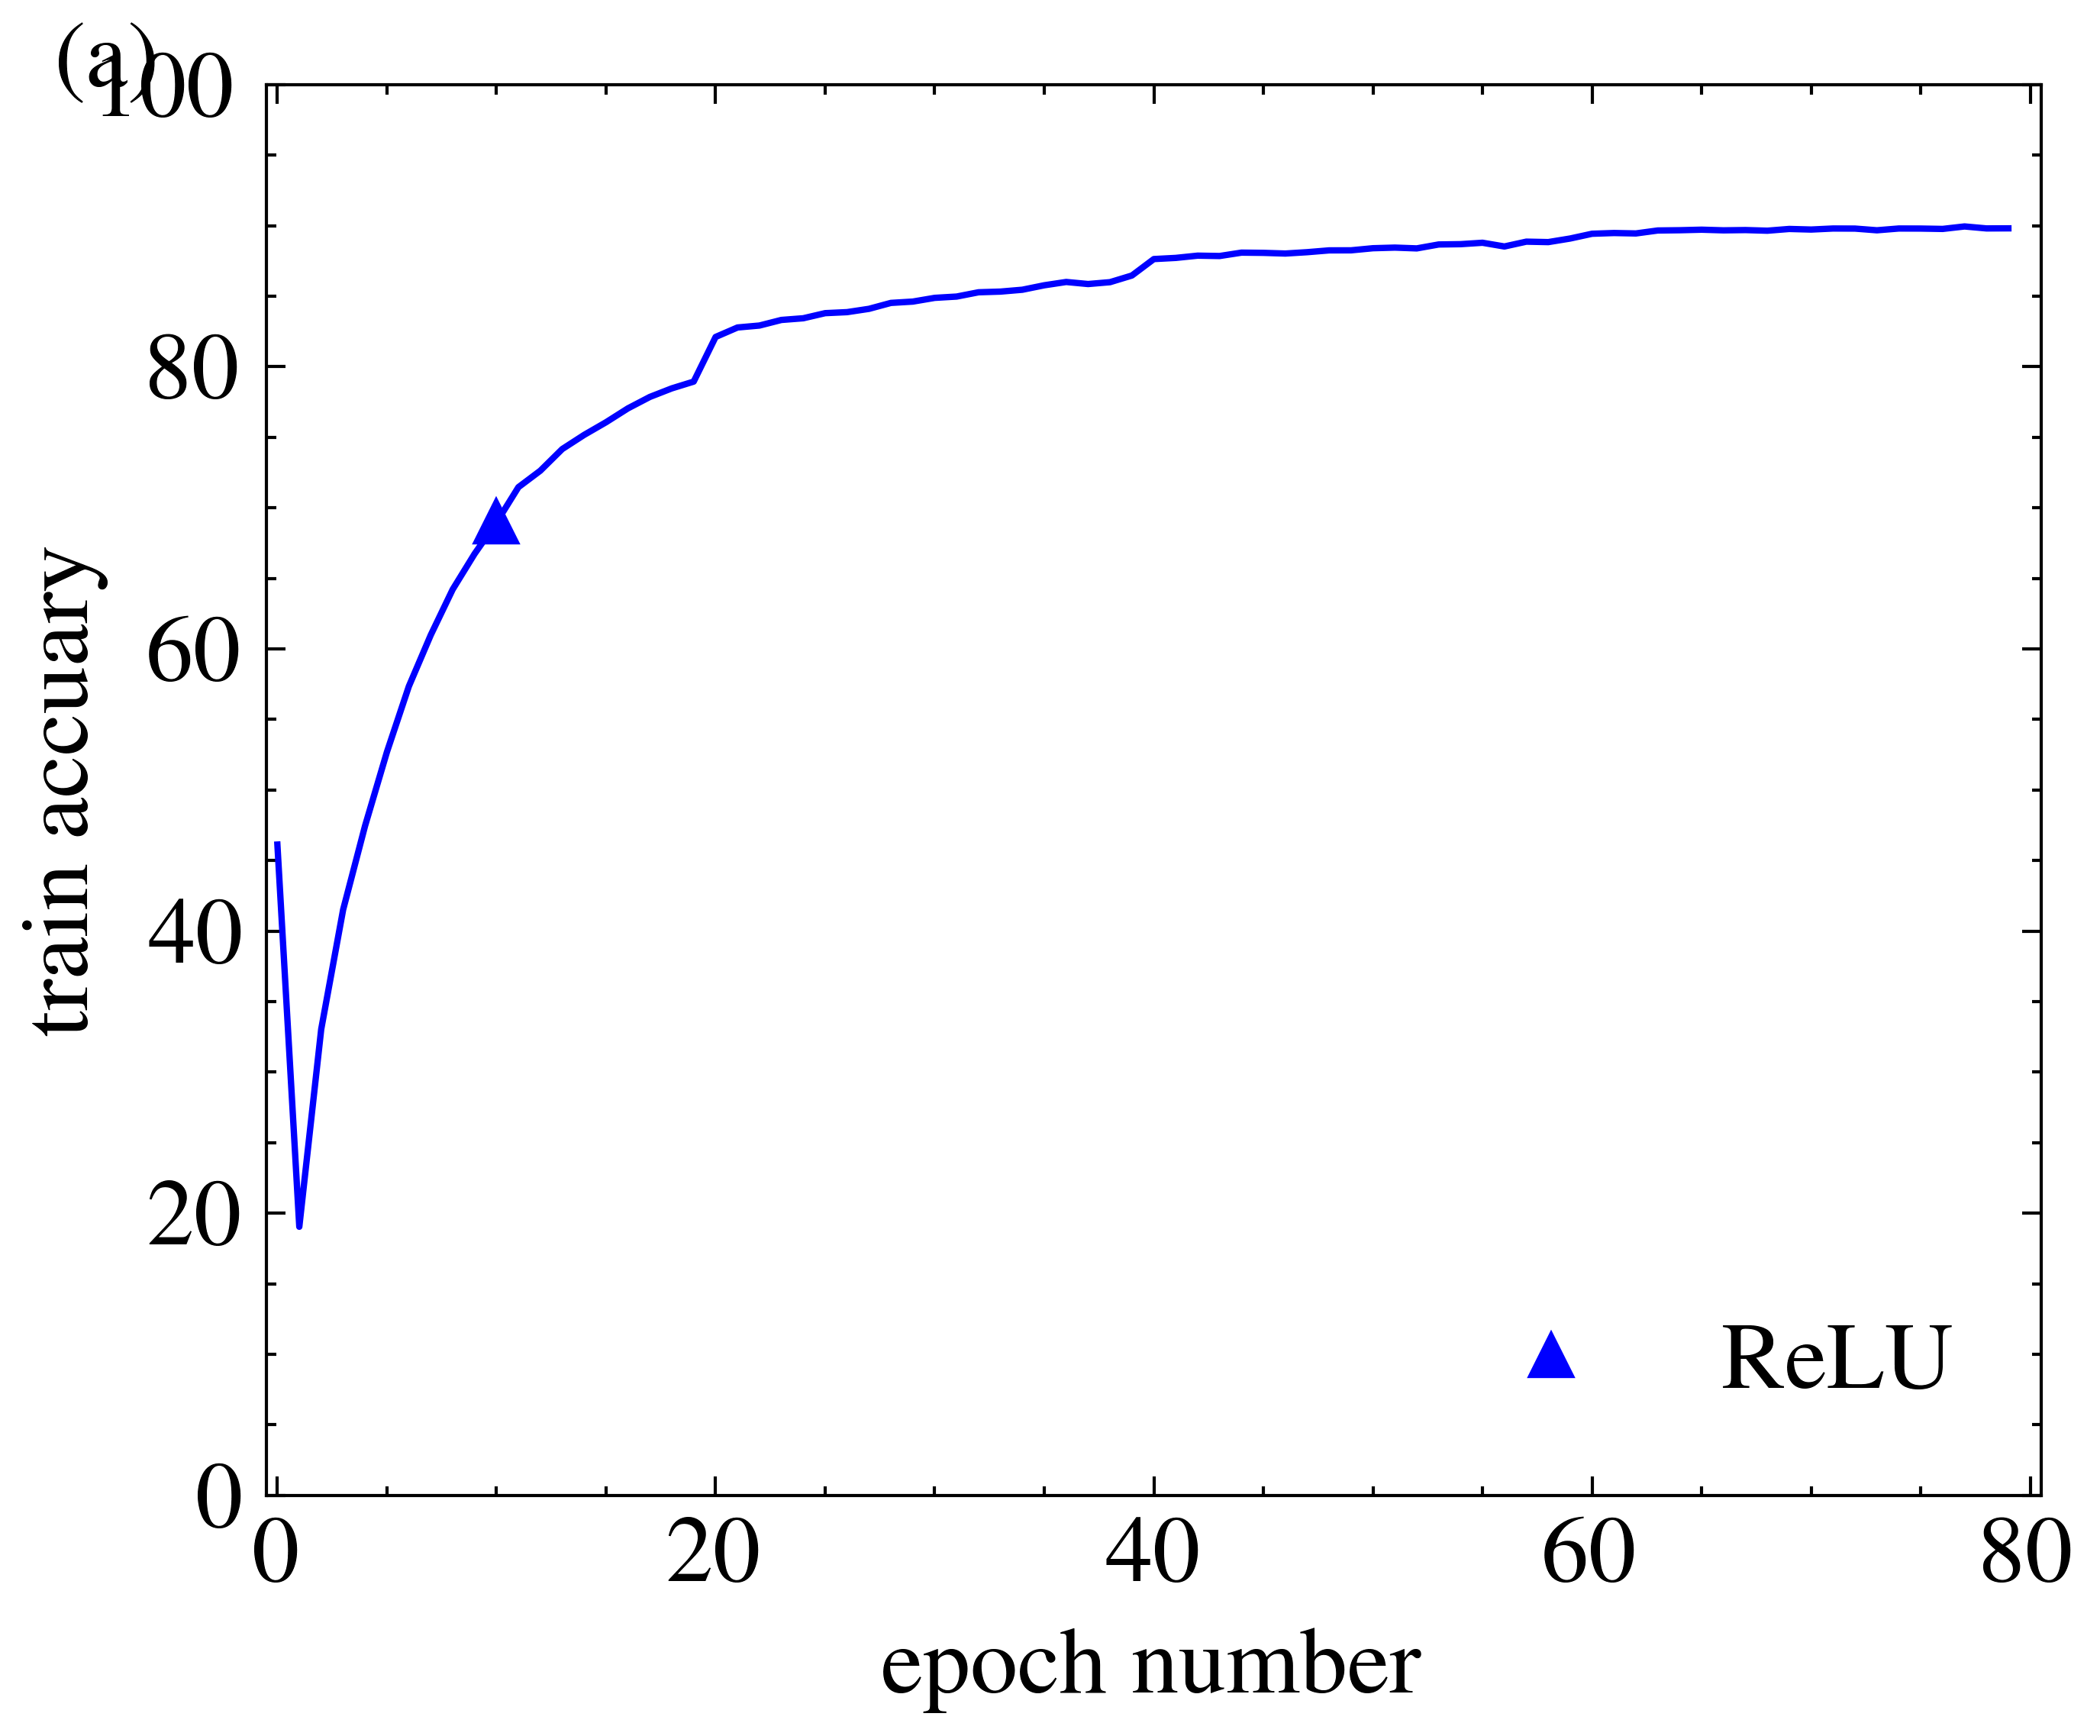

In [2]:
import pandas as pd
historycifarelu=pd.read_csv('D:/Neural networks2023/historycifarelu.csv')
#import scienceplots 
import math
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel('train accuary', fontsize=15, labelpad = -1)
ax.set_xlim(-0.5, 80.5)
ax.set_ylim(0, 100)


xrelu = range(0, 80)
yrelu = historycifarelu['relu_train_acc']
plt.plot(xrelu, yrelu, '-',color ='b')
plt.plot(xrelu[10], yrelu[10], '^',color ='b',label='ReLU')



ax.legend(loc='lower right', fontsize=15)
ax.text(-10, 99.8, '(a)',fontdict={'size': 15, 'color':  'black'})
plt.show()
#fig.savefig('D:/IEEE 2022 general AF/neural networks2023/figminsta.eps', dpi=800)

In [8]:
SIGMOID

In [4]:
class custom(nn.Module):  # 第一类激活函数
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.randn(1))  # 1个可学习参数 sigma
        #self.theta = nn.Parameter(torch.randn(1, width))
    def forward(self, input):
        temp = 0.5+torch.erf((input)/self.sigma/math.sqrt(2))/2  # 前向传播
        return temp

class Pgelu(nn.Module): #带参数的gelu激活函数
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.randn(1)) #两个可学习参数 sigma 和 theta

    def forward(self, input):
        #temp1=self.sigma*torch.exp(-input*input/2/self.sigma/self.sigma)/2.506628 #具体表达式
        temp2=input/2*(1+torch.erf(input/math.sqrt(2)/self.sigma))
        return temp2


# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.sigmoid = nn.Sigmoid()
        #self.relu = nn.ReLU()
        #self.pgelu1 = Pgelu()
        #self.gelu = nn.GELU()
        #self.custom1 = custom()
        #self.custom2 = custom()
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        #out = self.relu(out)
        #out = self.pgelu1(out)
        out = self.sigmoid(out)
        #out = self.gelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        #out = self.relu(out)
        #out = self.pgelu2(out)
        out = self.sigmoid(out)
        #out = self.gelu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        #self.relu = nn.ReLU()
        
        #self.pgelu3 = Pgelu()
        self.sigmoid = nn.Sigmoid()
        #self.gelu = nn.GELU()
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        #out = self.relu(out)
        #out = self.pgelu3(out)
        out = self.sigmoid(out)
        #out = self.gelu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

In [5]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.99,0.99))

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model

historycifasigmoid={'SIGMOID_train_loss':[],'SIGMOID_valid_loss':[],'SIGMOID_train_acc':[],'SIGMOID_valid_acc':[]}
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    SIGMOID_train_loss,SIGMOID_train_correct=0.0,0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        SIGMOID_train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(outputs.data, 1)#最大化输出得到标签0-9
        SIGMOID_train_correct += (predictions == labels).sum().item() #对比标签得到正确的标签个数 

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

     #Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)
    SIGMOID_valid_loss, SIGMOID_val_correct = 0.0, 0
    model.eval()#评估模式,非训练模式,batch normalization 和 dropout关闭
    for images, labels in test_loader:

        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        loss=criterion(outputs,labels)
        SIGMOID_valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(outputs.data,1)#最大化输出得到标签0-9
        SIGMOID_val_correct+=(predictions == labels).sum().item()#对比标签得到正确的标签个数
        
    SIGMOID_train_loss = SIGMOID_train_loss / len(train_loader.sampler)#除以48000
    SIGMOID_train_acc = SIGMOID_train_correct / len(train_loader.sampler)*100
    SIGMOID_valid_loss = SIGMOID_valid_loss / len(test_loader.sampler)#除以12000
    SIGMOID_valid_acc = SIGMOID_val_correct / len(test_loader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs,
                                                                                         SIGMOID_train_loss,
                                                                                         SIGMOID_valid_loss,
                                                                                         SIGMOID_train_acc,
                                                                                        SIGMOID_valid_acc))
    historycifasigmoid['SIGMOID_train_loss'].append(SIGMOID_train_loss)#每次训练和验证记录下来，后面画图   
    historycifasigmoid['SIGMOID_valid_loss'].append(SIGMOID_valid_loss)  
    historycifasigmoid['SIGMOID_train_acc'].append(SIGMOID_train_acc)  
    historycifasigmoid['SIGMOID_valid_acc'].append(SIGMOID_valid_acc)

Epoch [1/80], Step [100/500] Loss: 2.0772
Epoch [1/80], Step [200/500] Loss: 1.8266
Epoch [1/80], Step [300/500] Loss: 1.9285
Epoch [1/80], Step [400/500] Loss: 1.8429
Epoch [1/80], Step [500/500] Loss: 1.8078
Epoch:1/80 	 AVERAGE TL:1.9579 AVERAGE VL:2.1224 	 AVERAGE TA:24.24 %  AVERAGE VA:18.52 %
Epoch [2/80], Step [100/500] Loss: 1.8463
Epoch [2/80], Step [200/500] Loss: 2.0010
Epoch [2/80], Step [300/500] Loss: 1.8649
Epoch [2/80], Step [400/500] Loss: 1.9006
Epoch [2/80], Step [500/500] Loss: 1.7925
Epoch:2/80 	 AVERAGE TL:1.9038 AVERAGE VL:1.8136 	 AVERAGE TA:26.82 %  AVERAGE VA:31.00 %
Epoch [3/80], Step [100/500] Loss: 1.8648
Epoch [3/80], Step [200/500] Loss: 1.8324
Epoch [3/80], Step [300/500] Loss: 1.8310
Epoch [3/80], Step [400/500] Loss: 1.7101
Epoch [3/80], Step [500/500] Loss: 1.6990
Epoch:3/80 	 AVERAGE TL:1.7956 AVERAGE VL:1.7827 	 AVERAGE TA:30.72 %  AVERAGE VA:30.35 %
Epoch [4/80], Step [100/500] Loss: 1.6460
Epoch [4/80], Step [200/500] Loss: 1.8274
Epoch [4/80], St

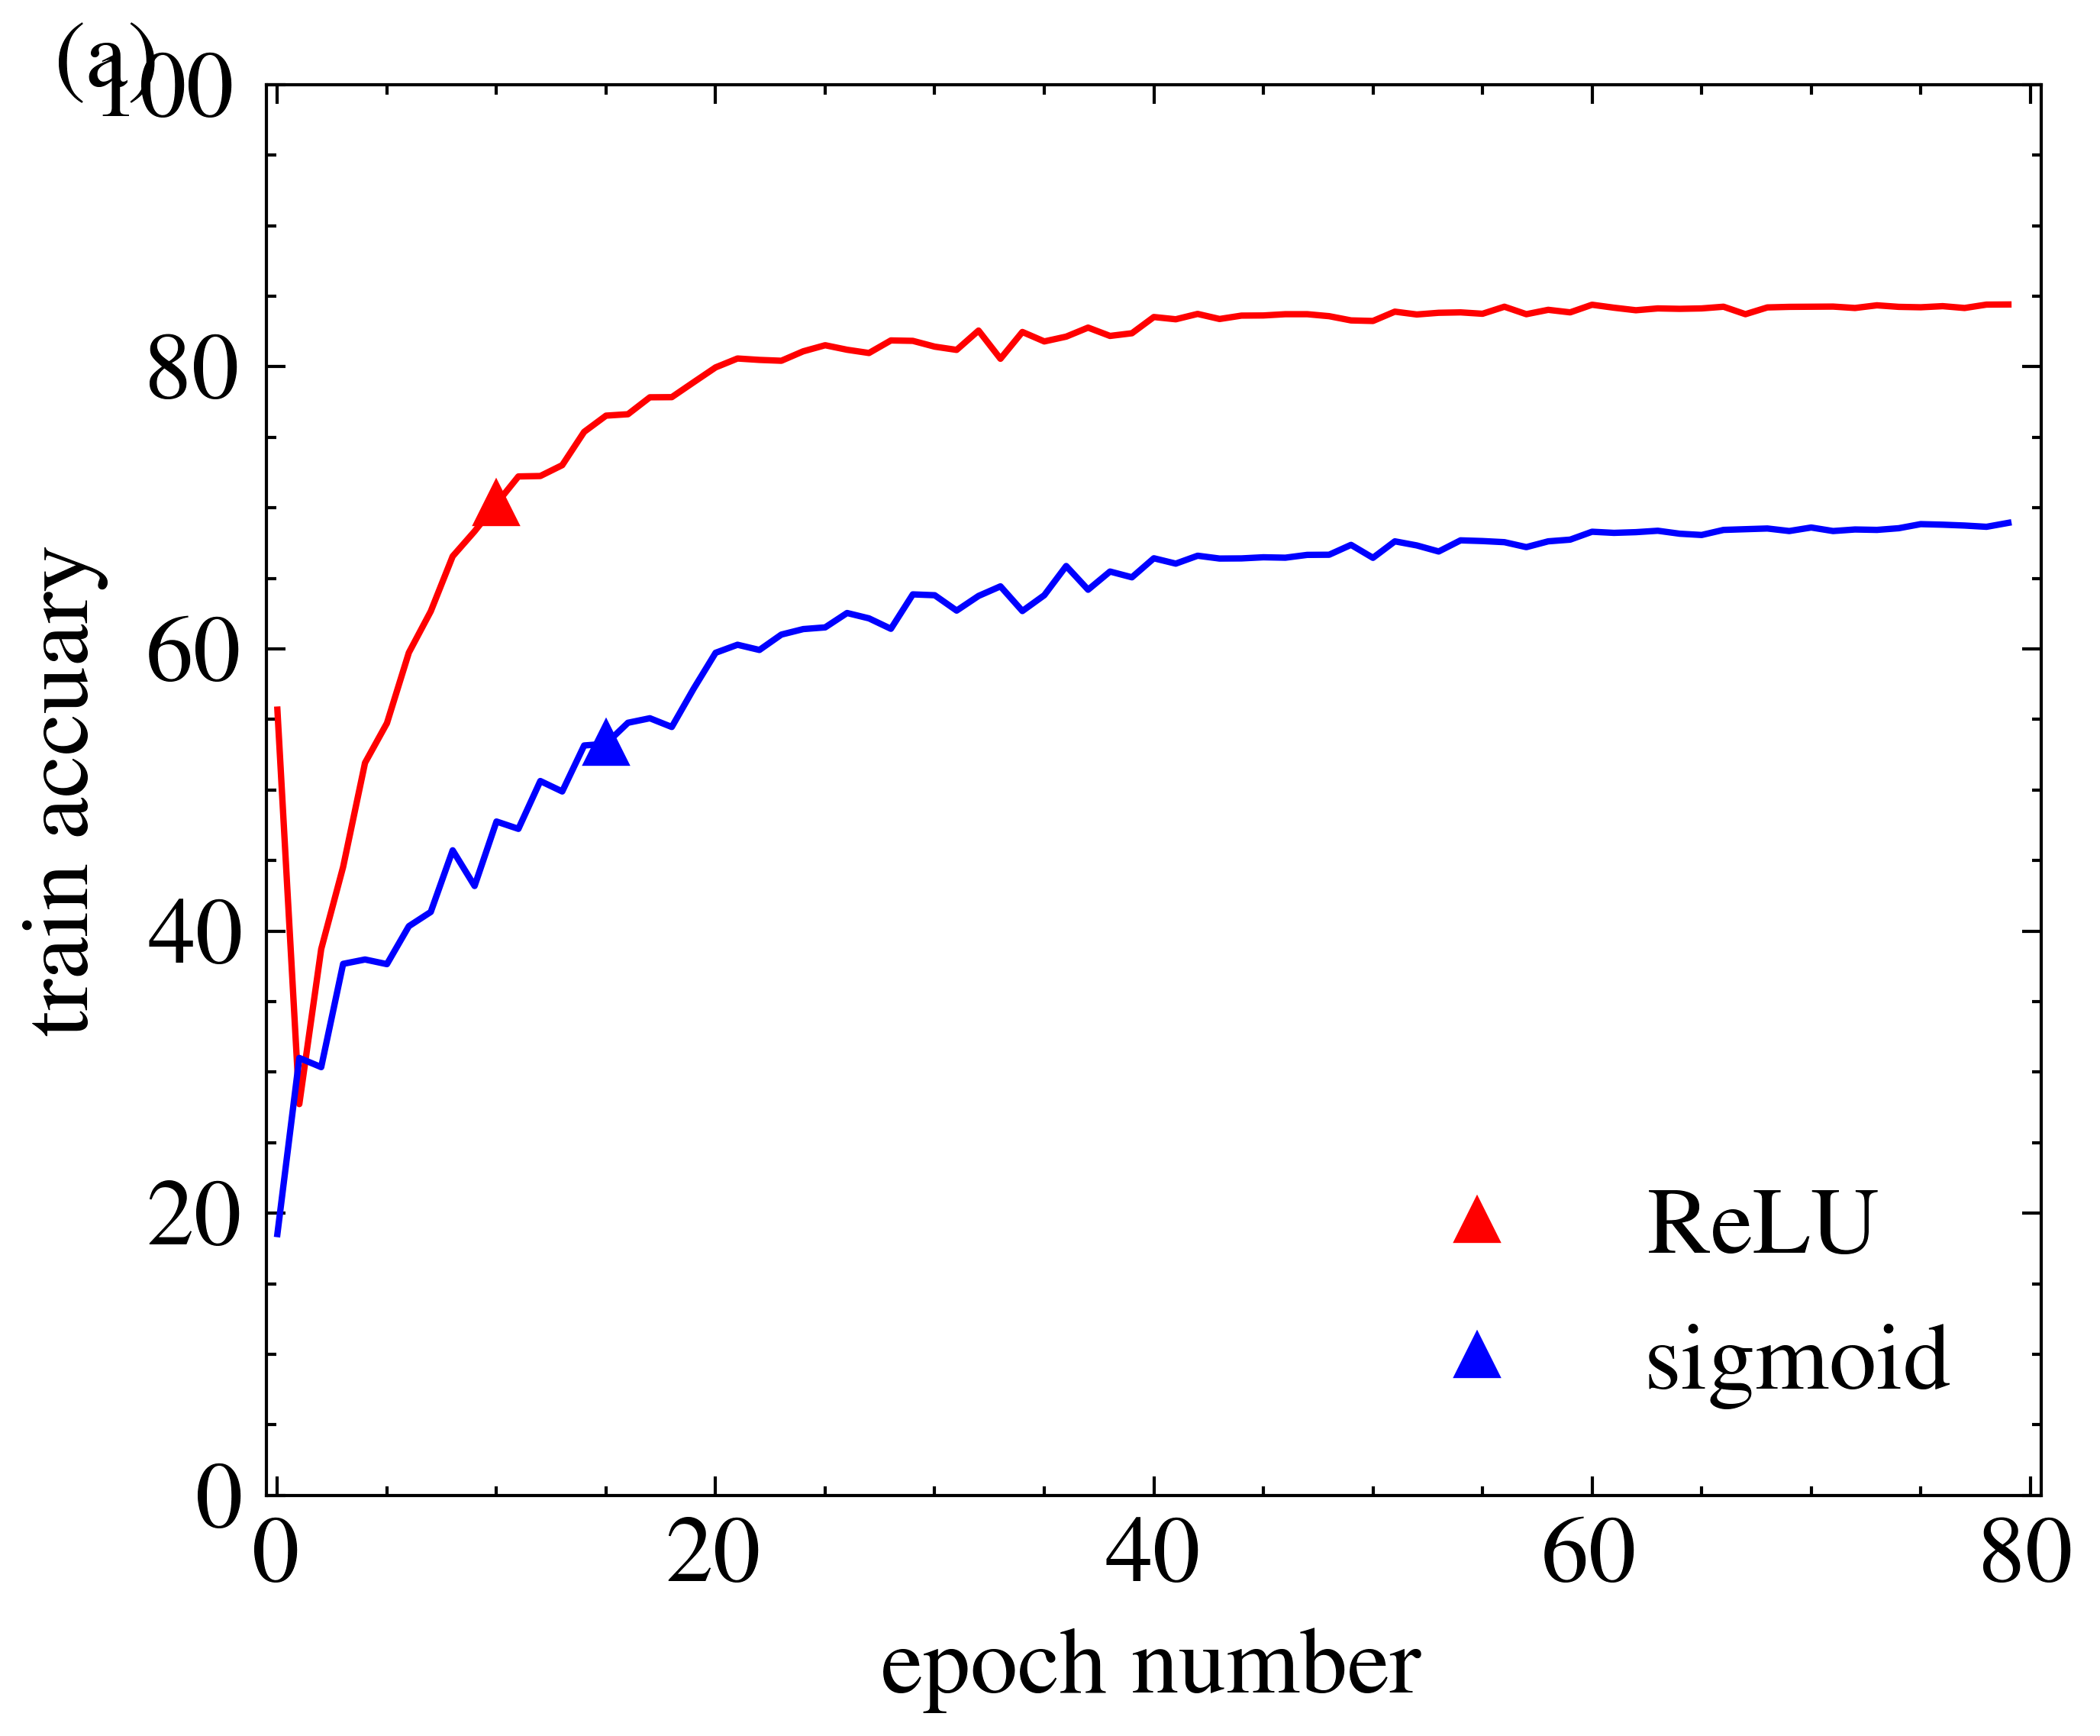

In [9]:
import pandas as pd
frame1=pd.DataFrame(historycifasigmoid)
frame1.to_csv('D:/Neural networks2023/historycifasigmoid.csv')

import pandas as pd
historycifarelu=pd.read_csv('D:/Neural networks2023/historycifarelu.csv')
historycifasigmoid=pd.read_csv('D:/Neural networks2023/historycifasigmoid.csv')
#import scienceplots 
import math
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel('train accuary', fontsize=15, labelpad = -1)
ax.set_xlim(-0.5, 80.5)
ax.set_ylim(0, 100)


xrelu = range(0, 80)
yrelu = historycifarelu['relu_valid_acc']
plt.plot(xrelu, yrelu, '-',color ='r')
plt.plot(xrelu[10], yrelu[10], '^',color ='r',label='ReLU')


xsigmoid = range(0, 80)
ysigmoid = historycifasigmoid['SIGMOID_valid_acc']
plt.plot(xsigmoid, ysigmoid, '-',color ='b')
plt.plot(xsigmoid[15], ysigmoid[15], '^',color ='b',label='sigmoid')


ax.legend(loc='lower right', fontsize=15)
ax.text(-10, 99.8, '(a)',fontdict={'size': 15, 'color':  'black'})
plt.show()
#fig.savefig('D:/IEEE 2022 general AF/neural networks2023/figminsta.eps', dpi=800)

In [ ]:
4GELU

In [2]:
# ---------------------------------------------------------------------------- #
# An implementation of https://arxiv.org/pdf/1512.03385.pdf                    #
# See section 4.2 for the model architecture on CIFAR-10                       #
# Some part of the code was referenced from below                              #
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py   #
# ---------------------------------------------------------------------------- #

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 80
learning_rate = 0.001

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=False)

Files already downloaded and verified


In [3]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.gelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.gelu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.gelu = nn.GELU()
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.gelu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

In [4]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate


historycifagelu={'GELU_train_loss':[],'GELU_valid_loss':[],'GELU_train_acc':[],'GELU_valid_acc':[]}
num_epochs=80

for epoch in range(num_epochs):
    GELU_train_loss,GELU_train_correct=0.0,0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        GELU_train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(outputs.data, 1)#最大化输出得到标签0-9
        GELU_train_correct += (predictions == labels).sum().item() #对比标签得到正确的标签个数   
        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)
    GELU_valid_loss, GELU_val_correct = 0.0, 0
    model.eval()#评估模式,非训练模式,batch normalization 和 dropout关闭
    for images, labels in test_loader:

        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        loss=criterion(outputs,labels)
        GELU_valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(outputs.data,1)#最大化输出得到标签0-9
        GELU_val_correct+=(predictions == labels).sum().item()#对比标签得到正确的标签个数

    GELU_train_loss = GELU_train_loss / len(train_loader.sampler)#除以48000
    GELU_train_acc = GELU_train_correct / len(train_loader.sampler)*100
    GELU_valid_loss = GELU_valid_loss / len(test_loader.sampler)#除以12000
    GELU_valid_acc = GELU_val_correct / len(test_loader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs,
                                                                                         GELU_train_loss,
                                                                                         GELU_valid_loss,
                                                                                         GELU_train_acc,
                                                                                        GELU_valid_acc))
    historycifagelu['GELU_train_loss'].append(GELU_train_loss)#每次训练和验证记录下来，后面画图   
    historycifagelu['GELU_valid_loss'].append(GELU_valid_loss)  
    historycifagelu['GELU_train_acc'].append(GELU_train_acc)  
    historycifagelu['GELU_valid_acc'].append(GELU_valid_acc)  

Epoch [1/80], Step [100/500] Loss: 1.5446
Epoch [1/80], Step [200/500] Loss: 1.5574
Epoch [1/80], Step [300/500] Loss: 1.2885
Epoch [1/80], Step [400/500] Loss: 1.3840
Epoch [1/80], Step [500/500] Loss: 0.9490
Epoch:1/80 	 AVERAGE TL:1.4399 AVERAGE VL:1.1927 	 AVERAGE TA:47.23 %  AVERAGE VA:56.98 %
Epoch [2/80], Step [100/500] Loss: 1.2157
Epoch [2/80], Step [200/500] Loss: 1.1286
Epoch [2/80], Step [300/500] Loss: 0.9113
Epoch [2/80], Step [400/500] Loss: 1.0455
Epoch [2/80], Step [500/500] Loss: 0.8784
Epoch:2/80 	 AVERAGE TL:1.1936 AVERAGE VL:1.0305 	 AVERAGE TA:57.07 %  AVERAGE VA:62.97 %
Epoch [3/80], Step [100/500] Loss: 1.0134
Epoch [3/80], Step [200/500] Loss: 0.9310
Epoch [3/80], Step [300/500] Loss: 0.8075
Epoch [3/80], Step [400/500] Loss: 0.9583
Epoch [3/80], Step [500/500] Loss: 0.8360
Epoch:3/80 	 AVERAGE TL:0.9656 AVERAGE VL:0.8642 	 AVERAGE TA:65.63 %  AVERAGE VA:69.20 %
Epoch [4/80], Step [100/500] Loss: 0.8779
Epoch [4/80], Step [200/500] Loss: 0.7932
Epoch [4/80], St

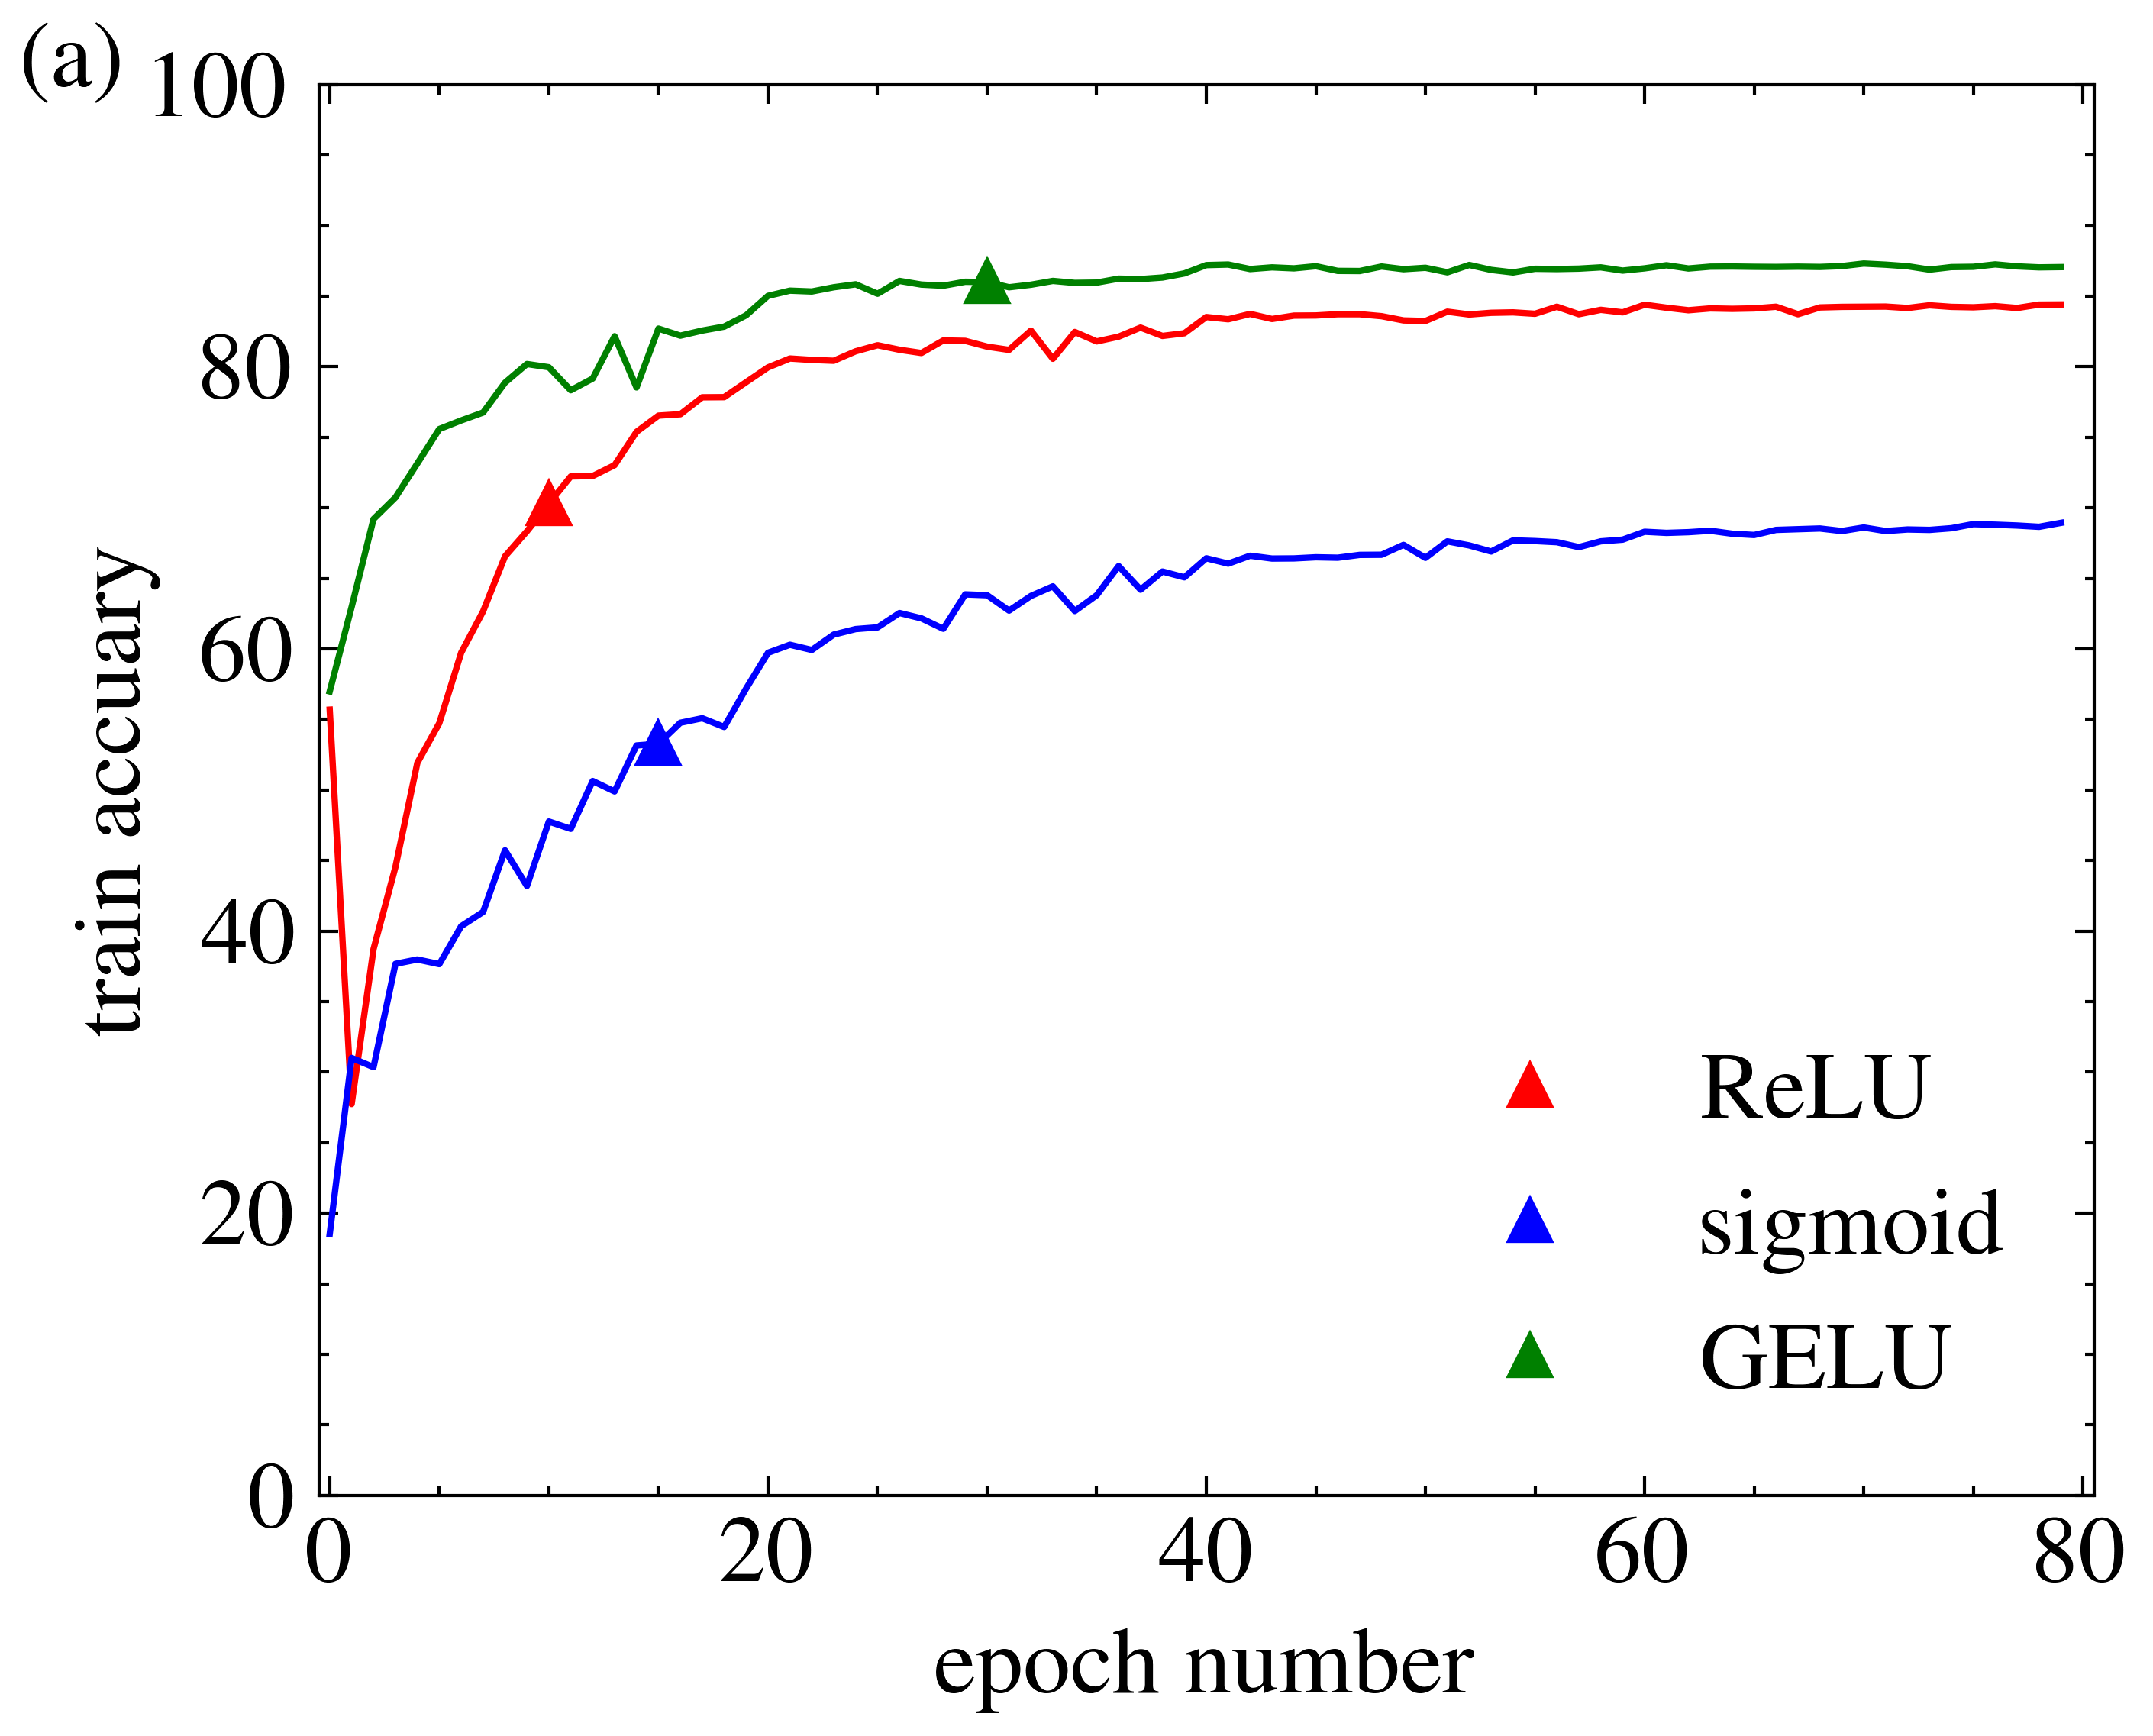

In [11]:
import pandas as pd
frame1=pd.DataFrame(historycifagelu)
frame1.to_csv('D:/Neural networks2023/historycifagelu.csv')

import pandas as pd
historycifarelu=pd.read_csv('D:/Neural networks2023/historycifarelu.csv')
historycifasigmoid=pd.read_csv('D:/Neural networks2023/historycifasigmoid.csv')
historycifagelu=pd.read_csv('D:/Neural networks2023/historycifagelu.csv')
#import scienceplots 
import math
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel('train accuary', fontsize=15, labelpad = -1)
ax.set_xlim(-0.5, 80.5)
ax.set_ylim(0, 100)


xrelu = range(0, 80)
yrelu = historycifarelu['relu_valid_acc']
plt.plot(xrelu, yrelu, '-',color ='r')
plt.plot(xrelu[10], yrelu[10], '^',color ='r',label='ReLU')


xsigmoid = range(0, 80)
ysigmoid = historycifasigmoid['SIGMOID_valid_acc']
plt.plot(xsigmoid, ysigmoid, '-',color ='b')
plt.plot(xsigmoid[15], ysigmoid[15], '^',color ='b',label='sigmoid')


xgelu = range(0, 80)
ygelu = historycifagelu['GELU_valid_acc']
plt.plot(xgelu, ygelu, '-',color ='g')
plt.plot(xgelu[30], ygelu[30], '^',color ='g',label='GELU')

ax.legend(loc='lower right', fontsize=15)
ax.text(-14, 99.8, '(a)',fontdict={'size': 15, 'color':  'black'})
plt.show()
#fig.savefig('D:/IEEE 2022 general AF/neural networks2023/figminsta.eps', dpi=800)

In [ ]:
5PGELU

In [2]:
class custom(nn.Module):  # 第一类激活函数
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.randn(1))  # 1个可学习参数 sigma
        #self.theta = nn.Parameter(torch.randn(1, width))
    def forward(self, input):
        temp = 0.5+torch.erf((input)/self.sigma/math.sqrt(2))/2  # 前向传播
        return temp

class Pgelu(nn.Module): #带参数的gelu激活函数
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.randn(1)) #两个可学习参数 sigma 和 theta

    def forward(self, input):
        #temp1=self.sigma*torch.exp(-input*input/2/self.sigma/self.sigma)/2.506628 #具体表达式
        temp2=input/2*(1+torch.erf(input/math.sqrt(2)/self.sigma))
        return temp2


# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        #self.relu = nn.ReLU()
        self.pgelu1 = Pgelu()
        self.pgelu2 = Pgelu()
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        #out = self.relu(out)
        out = self.pgelu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.pgelu2(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        #self.relu = nn.ReLU()
        self.pgelu3 = Pgelu()
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        #out = self.relu(out)
        out = self.pgelu3(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
#model1 = ResidualBlock()
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

In [3]:
print(model)

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pgelu3): Pgelu()
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pgelu1): Pgelu()
      (pgelu2): Pgelu()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pgelu1): Pgelu()
      (pgelu2): Pgelu()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), 

In [6]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


#z1=model1.pgelu1.sigma 
#nn.init.constant_(z1,6)
#z1=model(ResidualBlock.pgelu1.sigma, ) 
#nn.init.constant_(z1,6)

z=model.pgelu3.sigma 
nn.init.constant_(z,6)
z101=model.layer1[0].pgelu1.sigma 
nn.init.constant_(z101,3)
z102=model.layer1[0].pgelu2.sigma 
nn.init.constant_(z102,3)
z111=model.layer1[1].pgelu1.sigma 
nn.init.constant_(z111,3)
z112=model.layer1[1].pgelu2.sigma 
nn.init.constant_(z112,3)
z201=model.layer2[0].pgelu1.sigma 
nn.init.constant_(z201,3)
z202=model.layer2[0].pgelu2.sigma 
nn.init.constant_(z202,3)
z211=model.layer2[1].pgelu1.sigma 
nn.init.constant_(z211,3)
z212=model.layer2[1].pgelu2.sigma 
nn.init.constant_(z212,3)
z301=model.layer3[0].pgelu1.sigma 
nn.init.constant_(z301,3)
z302=model.layer3[0].pgelu2.sigma 
nn.init.constant_(z302,3)
z311=model.layer3[1].pgelu1.sigma 
nn.init.constant_(z311,3)
z312=model.layer3[1].pgelu2.sigma 
nn.init.constant_(z312,3)


# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate


historycifapgelu={'PGELU_train_loss':[],'PGELU_valid_loss':[],'PGELU_train_acc':[],'PGELU_valid_acc':[]}
num_epochs=80

for epoch in range(num_epochs):
    PGELU_train_loss,PGELU_train_correct=0.0,0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        PGELU_train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(outputs.data, 1)#最大化输出得到标签0-9
        PGELU_train_correct += (predictions == labels).sum().item() #对比标签得到正确的标签个数   
        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)
    PGELU_valid_loss, PGELU_val_correct = 0.0, 0
    model.eval()#评估模式,非训练模式,batch normalization 和 dropout关闭
    for images, labels in test_loader:

        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        loss=criterion(outputs,labels)
        PGELU_valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(outputs.data,1)#最大化输出得到标签0-9
        PGELU_val_correct+=(predictions == labels).sum().item()#对比标签得到正确的标签个数

    PGELU_train_loss = PGELU_train_loss / len(train_loader.sampler)#除以48000
    PGELU_train_acc = PGELU_train_correct / len(train_loader.sampler)*100
    PGELU_valid_loss = PGELU_valid_loss / len(test_loader.sampler)#除以12000
    PGELU_valid_acc = PGELU_val_correct / len(test_loader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs,
                                                                                         PGELU_train_loss,
                                                                                         PGELU_valid_loss,
                                                                                         PGELU_train_acc,
                                                                                        PGELU_valid_acc))
    historycifapgelu['PGELU_train_loss'].append(PGELU_train_loss)#每次训练和验证记录下来，后面画图   
    historycifapgelu['PGELU_valid_loss'].append(PGELU_valid_loss)  
    historycifapgelu['PGELU_train_acc'].append(PGELU_train_acc)  
    historycifapgelu['PGELU_valid_acc'].append(PGELU_valid_acc)  

Epoch [1/80], Step [100/500] Loss: 1.7572
Epoch [1/80], Step [200/500] Loss: 1.5113
Epoch [1/80], Step [300/500] Loss: 1.3881
Epoch [1/80], Step [400/500] Loss: 1.2048
Epoch [1/80], Step [500/500] Loss: 1.3834
Epoch:1/80 	 AVERAGE TL:1.4755 AVERAGE VL:1.3564 	 AVERAGE TA:45.69 %  AVERAGE VA:52.80 %
Epoch [2/80], Step [100/500] Loss: 1.1730
Epoch [2/80], Step [200/500] Loss: 1.2694
Epoch [2/80], Step [300/500] Loss: 0.9260
Epoch [2/80], Step [400/500] Loss: 0.9109
Epoch [2/80], Step [500/500] Loss: 0.7939
Epoch:2/80 	 AVERAGE TL:1.1056 AVERAGE VL:0.9849 	 AVERAGE TA:59.99 %  AVERAGE VA:65.21 %
Epoch [3/80], Step [100/500] Loss: 0.8714
Epoch [3/80], Step [200/500] Loss: 0.8115
Epoch [3/80], Step [300/500] Loss: 0.9316
Epoch [3/80], Step [400/500] Loss: 0.8627
Epoch [3/80], Step [500/500] Loss: 0.8617
Epoch:3/80 	 AVERAGE TL:0.9083 AVERAGE VL:0.8442 	 AVERAGE TA:67.60 %  AVERAGE VA:70.24 %
Epoch [4/80], Step [100/500] Loss: 1.0293
Epoch [4/80], Step [200/500] Loss: 0.8597
Epoch [4/80], St

In [7]:
import pandas as pd
frame1=pd.DataFrame(historycifapgelu)
frame1.to_csv('D:/IEEE 2022 general AF/neural networks2023/historycifapgelu.csv')

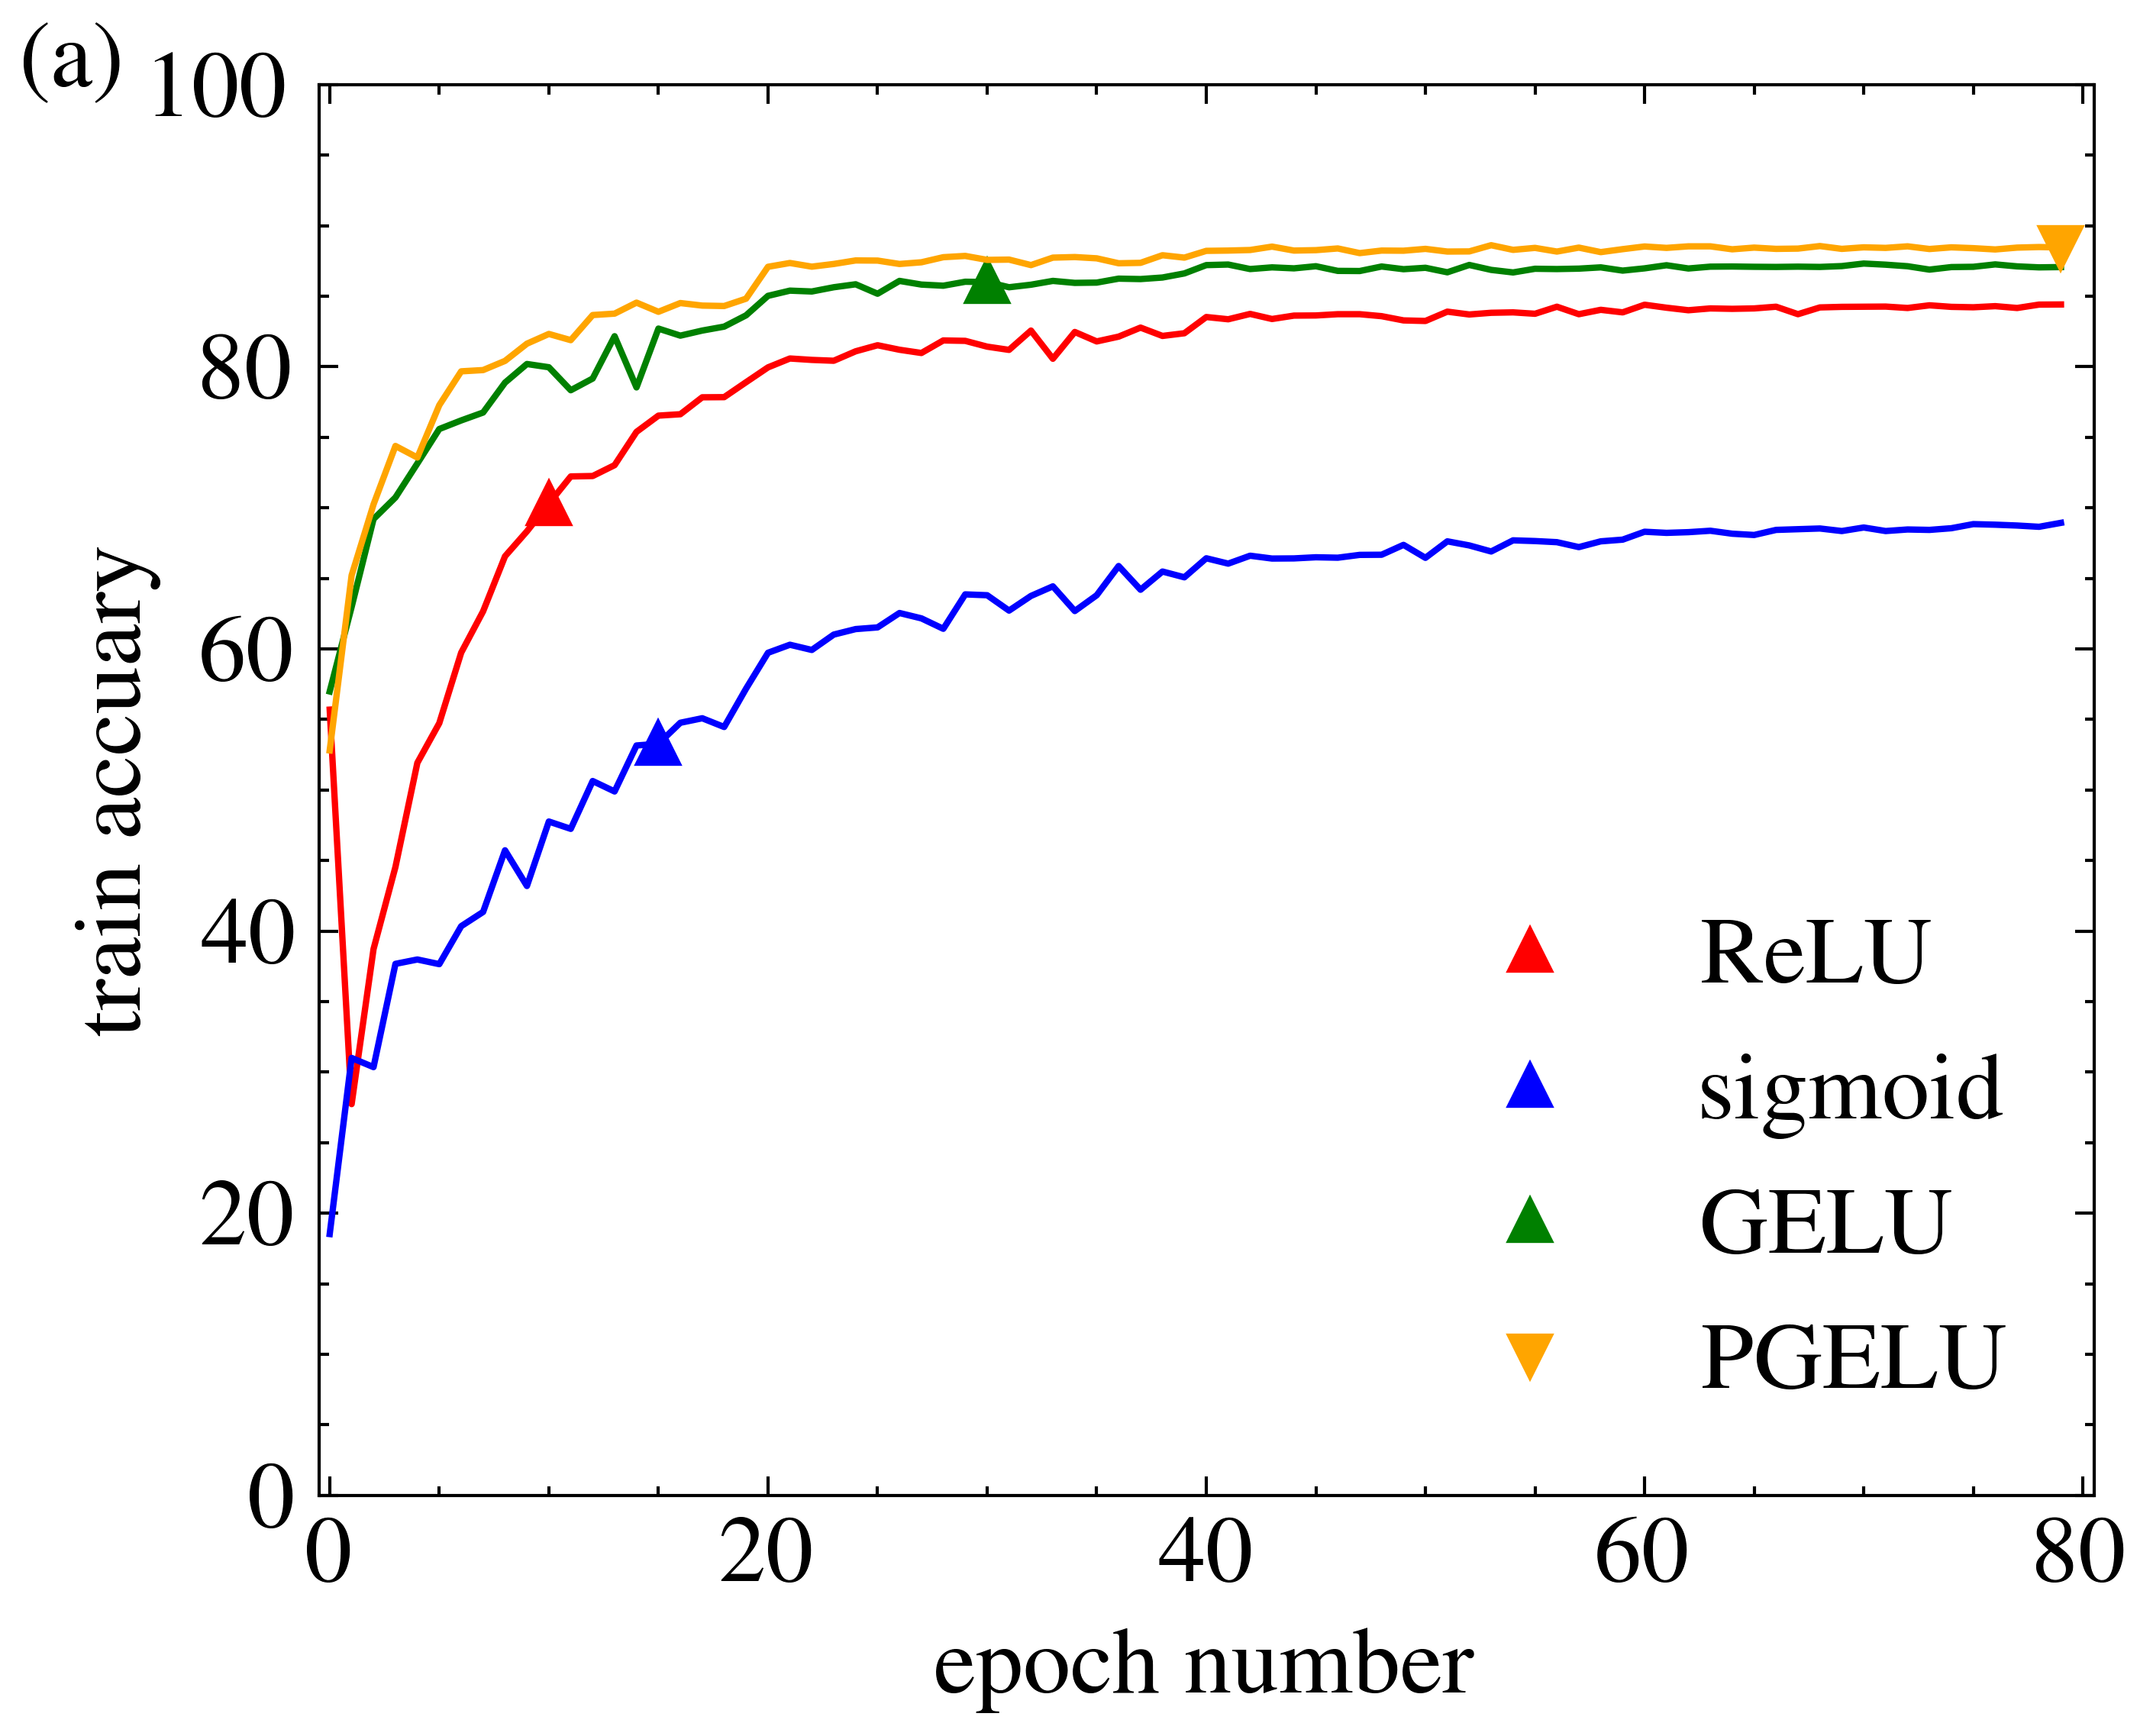

In [9]:
import pandas as pd
import scienceplots
historycifarelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historycifarelu.csv')
historycifasigmoid=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historycifasigmoid.csv')
historycifagelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historycifagelu.csv')
historycifapgelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historycifapgelu.csv')
#import scienceplots 
import math
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel('test accuary', fontsize=15, labelpad = -1)
ax.set_xlim(-0.5, 80.5)
ax.set_ylim(0, 100)


xrelu = range(0, 80)
yrelu = historycifarelu['relu_valid_acc']
plt.plot(xrelu, yrelu, '-',color ='r')
plt.plot(xrelu[10], yrelu[10], '^',color ='r',label='ReLU')


xsigmoid = range(0, 80)
ysigmoid = historycifasigmoid['SIGMOID_valid_acc']
plt.plot(xsigmoid, ysigmoid, '-',color ='b')
plt.plot(xsigmoid[15], ysigmoid[15], '^',color ='b',label='sigmoid')


xgelu = range(0, 80)
ygelu = historycifagelu['GELU_valid_acc']
plt.plot(xgelu, ygelu, '-',color ='g')
plt.plot(xgelu[30], ygelu[30], '^',color ='g',label='GELU')

xpgelu = range(0, 80)
ypgelu = historycifapgelu['PGELU_valid_acc']
plt.plot(xpgelu, ypgelu, '-',color ='orange')
plt.plot(xpgelu[79], ypgelu[79], 'v',color ='orange',label='PGELU')

ax.legend(loc='lower right', fontsize=15)
ax.text(-14, 99.8, '(a)',fontdict={'size': 15, 'color':  'black'})
plt.show()
#fig.savefig('D:/IEEE 2022 general AF/neural networks2023/figminsta.eps', dpi=800)

In [13]:
print(z)
print(z101)
print(z102)
print(z111)
print(z112)
print(z201)
print(z202)
print(z211)
print(z212)
print(z301)
print(z302)
print(z311)
print(z312)

Parameter containing:
tensor([5.8567], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([2.7335], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([2.9239], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([2.2889], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([2.7852], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([2.4114], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([3.0066], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([2.6777], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([3.1751], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([3.3937], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([3.8828], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([3.4294], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([3.5903], device='cuda:0', requires_grad=True)


In [14]:
total = sum([param.nelement() for param in model.parameters()])
 
print("Number of parameter: %.2fM" % (total/1e6))

Number of parameter: 0.20M


In [11]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [12]:
print(pytorch_total_params)

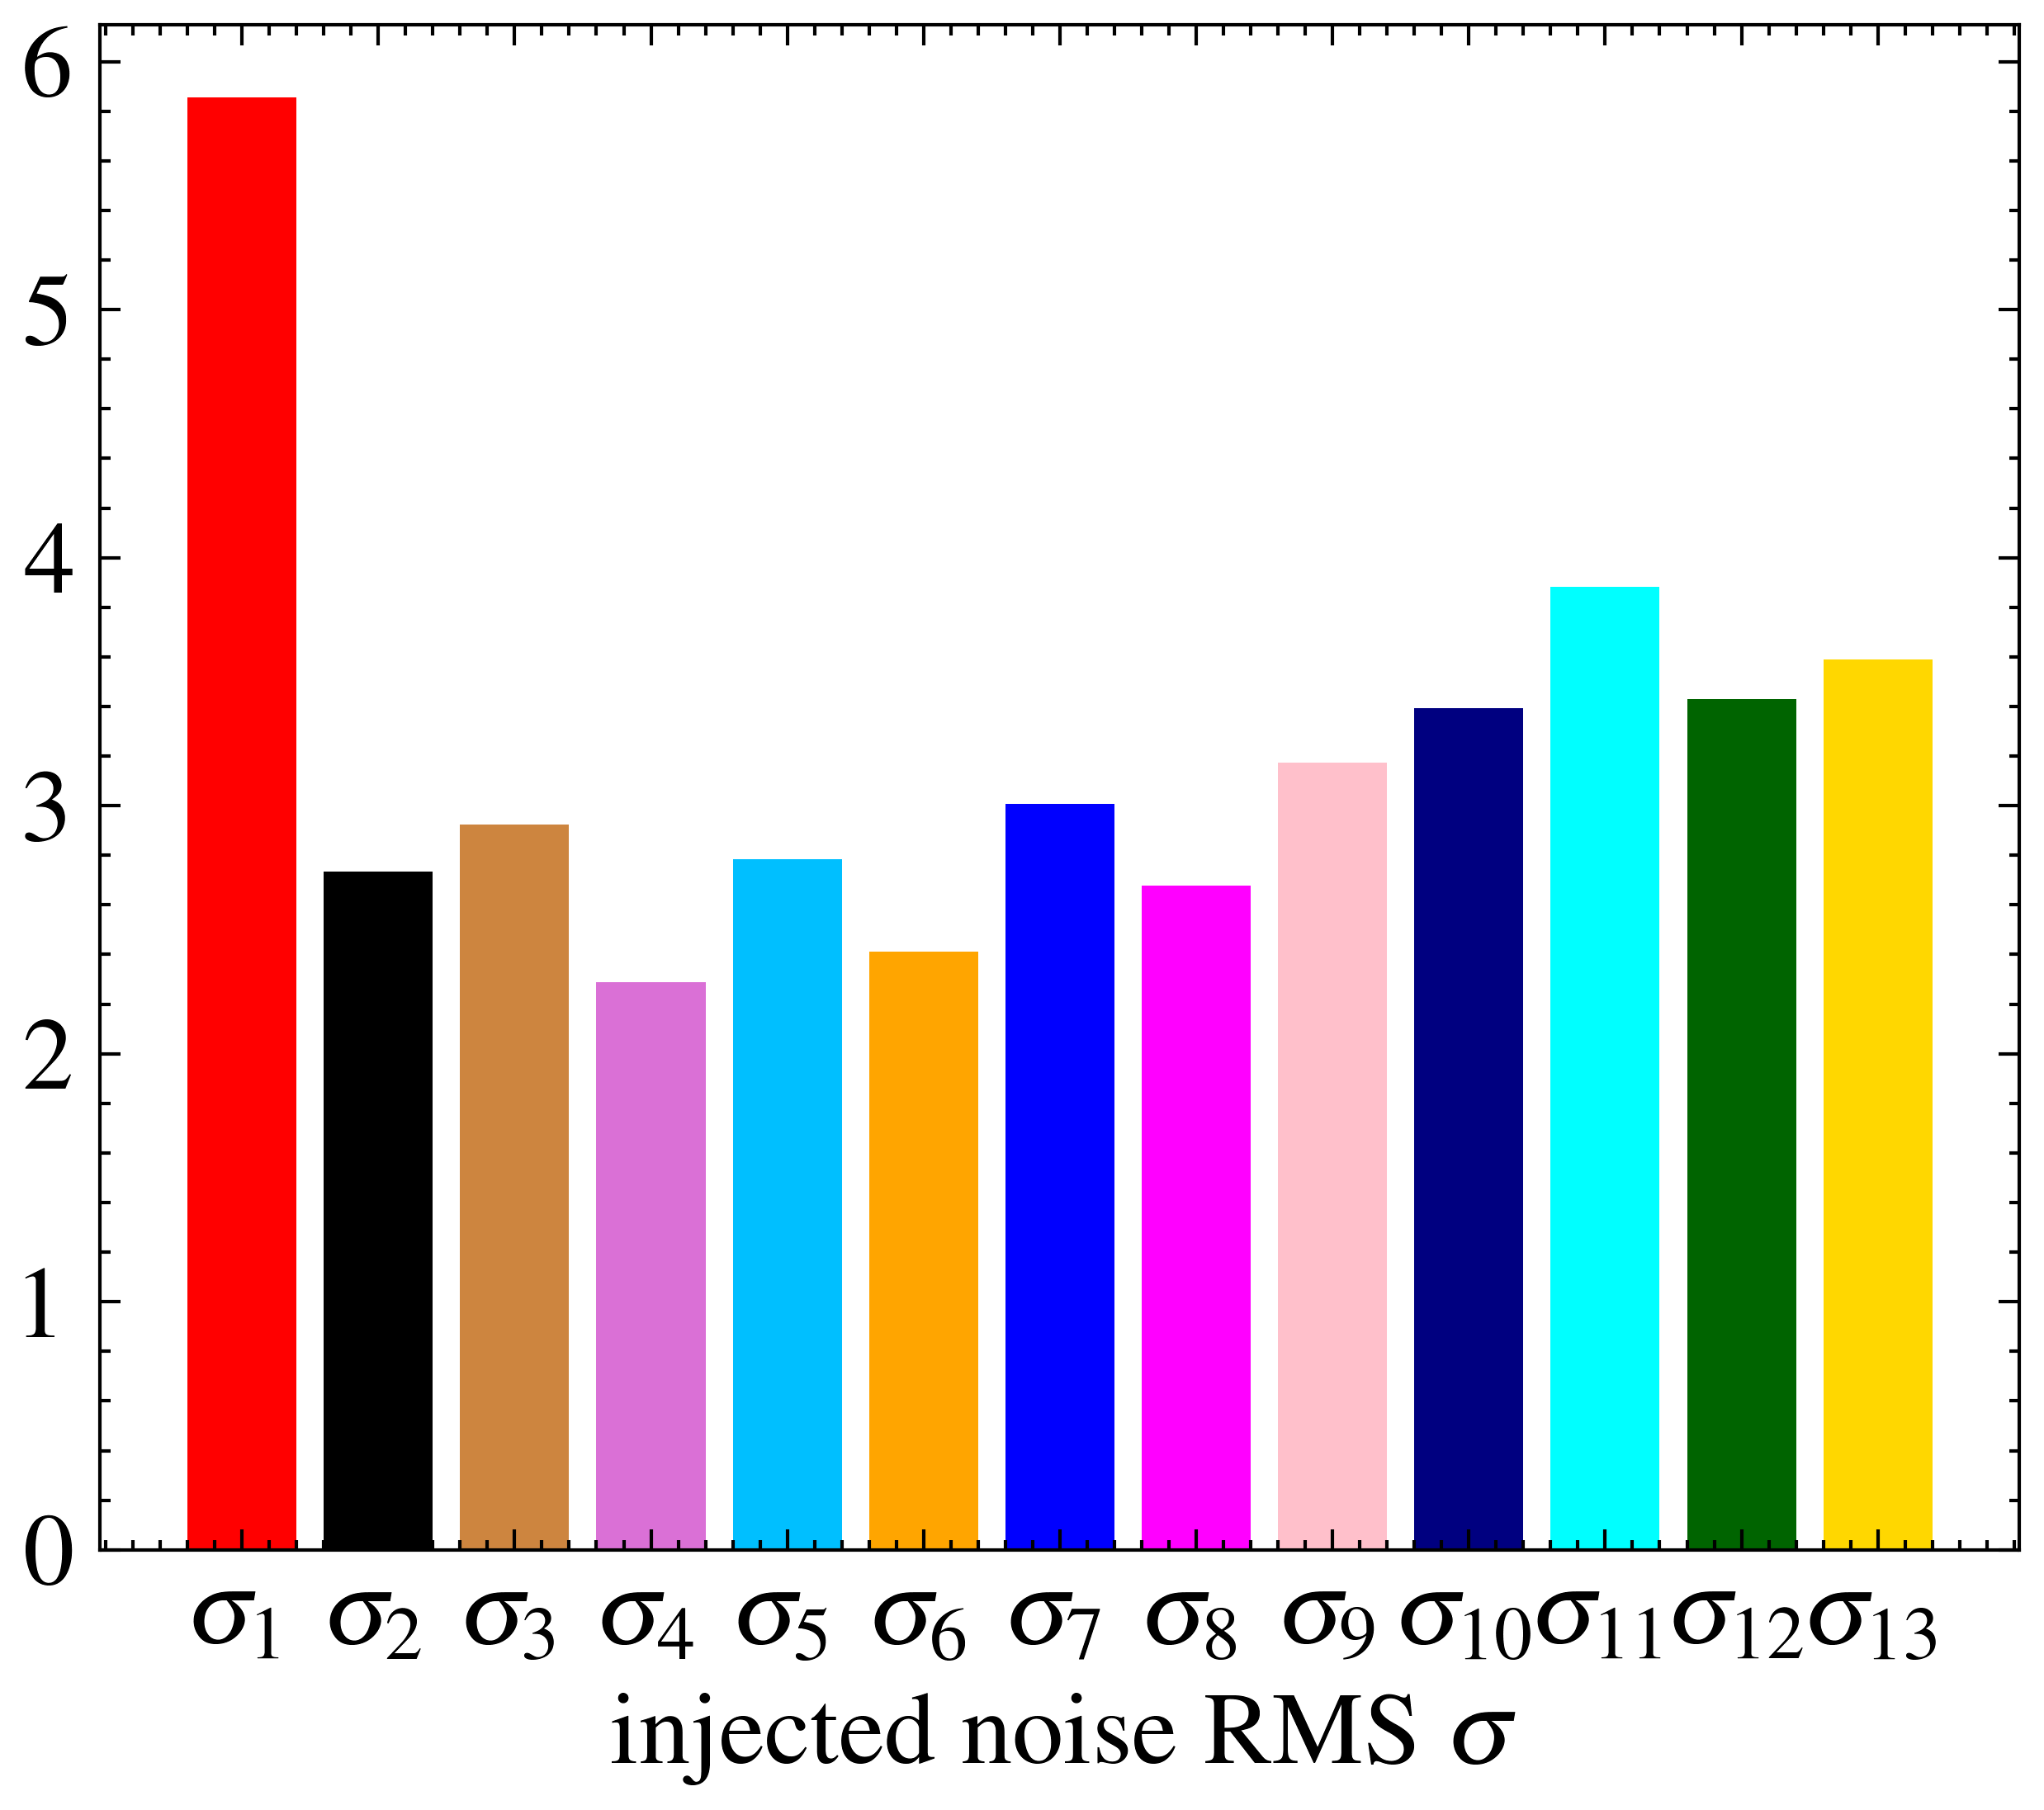

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('injected noise RMS $\sigma$', fontsize=15)
# 准备数据
x_data = [f"{i}" for i in range(1, 14)]
y_data = [5.8567,2.7335,2.9239,2.2889,2.7852,2.4114,3.0066,2.6777,3.1751,3.3937,3.8828,3.4294,3.5903]

#color=['red','black','peru','orchid','deepskyblue', 'orange','blue', 'magenta', 'pink', 'navy', 'cyan', 'darkgreen', 'gold']
# 画图，plt.bar()可以画柱状图
#for i in range(len(x_data)):
plt.bar(x_data, y_data, color=['red','black','peru','orchid','deepskyblue', 'orange','blue', 'magenta', 'pink', 'navy', 'cyan', 'darkgreen', 'gold'])
# 设置图片名称
# 设置x轴标签名
#plt.xlabel("injected noise RMS")
# 设置y轴标签名
# 显示
plt.xticks([f"{i}" for i in range(1, 14)],['$\sigma_1$', '$\sigma_2$', '$\sigma_3$', '$\sigma_4$', '$\sigma_5$', '$\sigma_6$', '$\sigma_7$', '$\sigma_8$', '$\sigma_9$','$\sigma_{10}$', '$\sigma_{11}$', '$\sigma_{12}$', '$\sigma_{13}$'])
plt.show()
fig.savefig('D:/IEEE 2022 general AF/neural networks2023/Fig5.eps', dpi=800)

In [24]:
#6.custom

In [29]:
class custom(nn.Module):  # 第一类激活函数
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.randn(1))  # 1个可学习参数 sigma
        #self.theta = nn.Parameter(torch.randn(1, width))
    def forward(self, input):
        temp = 0.5+torch.erf((input)/self.sigma/math.sqrt(2))/2  # 前向传播
        return temp

# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        #self.relu = nn.ReLU()
        # self.pgelu1 = Pgelu()
        # self.pgelu2 = Pgelu()
        self.custom1 = custom()
        self.custom2 = custom()
        
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        #out = self.relu(out)
        #out = self.pgelu1(out)
        out = self.custom1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        #out = self.pgelu2(out)
        out = self.custom2(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        #self.relu = nn.ReLU()
        #self.pgelu3 = Pgelu()
        self.custom3=custom()
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        #out = self.relu(out)
        #out = self.pgelu3(out)
        out = self.custom3(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
#model1 = ResidualBlock()
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

In [30]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.99,0.99))


z=model.custom3.sigma 
nn.init.constant_(z,5)
z101=model.layer1[0].custom1.sigma 
nn.init.constant_(z101,3)
z102=model.layer1[0].custom2.sigma 
nn.init.constant_(z102,3)
z111=model.layer1[1].custom1.sigma 
nn.init.constant_(z111,3)
z112=model.layer1[1].custom2.sigma 
nn.init.constant_(z112,3)
z201=model.layer2[0].custom1.sigma 
nn.init.constant_(z201,3)
z202=model.layer2[0].custom2.sigma 
nn.init.constant_(z202,3)
z211=model.layer2[1].custom1.sigma 
nn.init.constant_(z211,3)
z212=model.layer2[1].custom2.sigma 
nn.init.constant_(z212,3)
z301=model.layer3[0].custom1.sigma 
nn.init.constant_(z301,3)
z302=model.layer3[0].custom2.sigma 
nn.init.constant_(z302,3)
z311=model.layer3[1].custom1.sigma 
nn.init.constant_(z311,3)
z312=model.layer3[1].custom2.sigma 
nn.init.constant_(z312,3)


# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate


historycifageu={'GEU_train_loss':[],'GEU_valid_loss':[],'GEU_train_acc':[],'GEU_valid_acc':[]}
num_epochs=80

for epoch in range(num_epochs):
    GEU_train_loss,GEU_train_correct=0.0,0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        GEU_train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(outputs.data, 1)#最大化输出得到标签0-9
        GEU_train_correct += (predictions == labels).sum().item() #对比标签得到正确的标签个数   
        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)
    GEU_valid_loss, GEU_val_correct = 0.0, 0
    model.eval()#评估模式,非训练模式,batch normalization 和 dropout关闭
    for images, labels in test_loader:

        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        loss=criterion(outputs,labels)
        GEU_valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(outputs.data,1)#最大化输出得到标签0-9
        GEU_val_correct+=(predictions == labels).sum().item()#对比标签得到正确的标签个数

    GEU_train_loss = GEU_train_loss / len(train_loader.sampler)#除以48000
    GEU_train_acc = GEU_train_correct / len(train_loader.sampler)*100
    GEU_valid_loss = GEU_valid_loss / len(test_loader.sampler)#除以12000
    GEU_valid_acc = GEU_val_correct / len(test_loader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs,
                                                                                         GEU_train_loss,
                                                                                         GEU_valid_loss,
                                                                                         GEU_train_acc,
                                                                                        GEU_valid_acc))
    historycifageu['GEU_train_loss'].append(GEU_train_loss)#每次训练和验证记录下来，后面画图   
    historycifageu['GEU_valid_loss'].append(GEU_valid_loss)  
    historycifageu['GEU_train_acc'].append(GEU_train_acc)  
    historycifageu['GEU_valid_acc'].append(GEU_valid_acc) 

Epoch [1/80], Step [100/500] Loss: 2.1373
Epoch [1/80], Step [200/500] Loss: 2.0552
Epoch [1/80], Step [300/500] Loss: 1.8919
Epoch [1/80], Step [400/500] Loss: 1.9934
Epoch [1/80], Step [500/500] Loss: 1.8798
Epoch:1/80 	 AVERAGE TL:2.0522 AVERAGE VL:3.0806 	 AVERAGE TA:21.97 %  AVERAGE VA:12.00 %
Epoch [2/80], Step [100/500] Loss: 2.0443
Epoch [2/80], Step [200/500] Loss: 2.1217
Epoch [2/80], Step [300/500] Loss: 1.9456
Epoch [2/80], Step [400/500] Loss: 1.9779
Epoch [2/80], Step [500/500] Loss: 1.9972
Epoch:2/80 	 AVERAGE TL:1.9688 AVERAGE VL:1.9527 	 AVERAGE TA:23.36 %  AVERAGE VA:23.81 %
Epoch [3/80], Step [100/500] Loss: 1.9208
Epoch [3/80], Step [200/500] Loss: 1.8293
Epoch [3/80], Step [300/500] Loss: 2.0094
Epoch [3/80], Step [400/500] Loss: 1.9104
Epoch [3/80], Step [500/500] Loss: 1.8606
Epoch:3/80 	 AVERAGE TL:1.9009 AVERAGE VL:1.8344 	 AVERAGE TA:26.45 %  AVERAGE VA:29.79 %
Epoch [4/80], Step [100/500] Loss: 1.8271
Epoch [4/80], Step [200/500] Loss: 1.8993
Epoch [4/80], St

In [31]:
import pandas as pd
frame1=pd.DataFrame(historycifageu)
frame1.to_csv('D:/IEEE 2022 general AF/neural networks2023/historycifageu.csv')

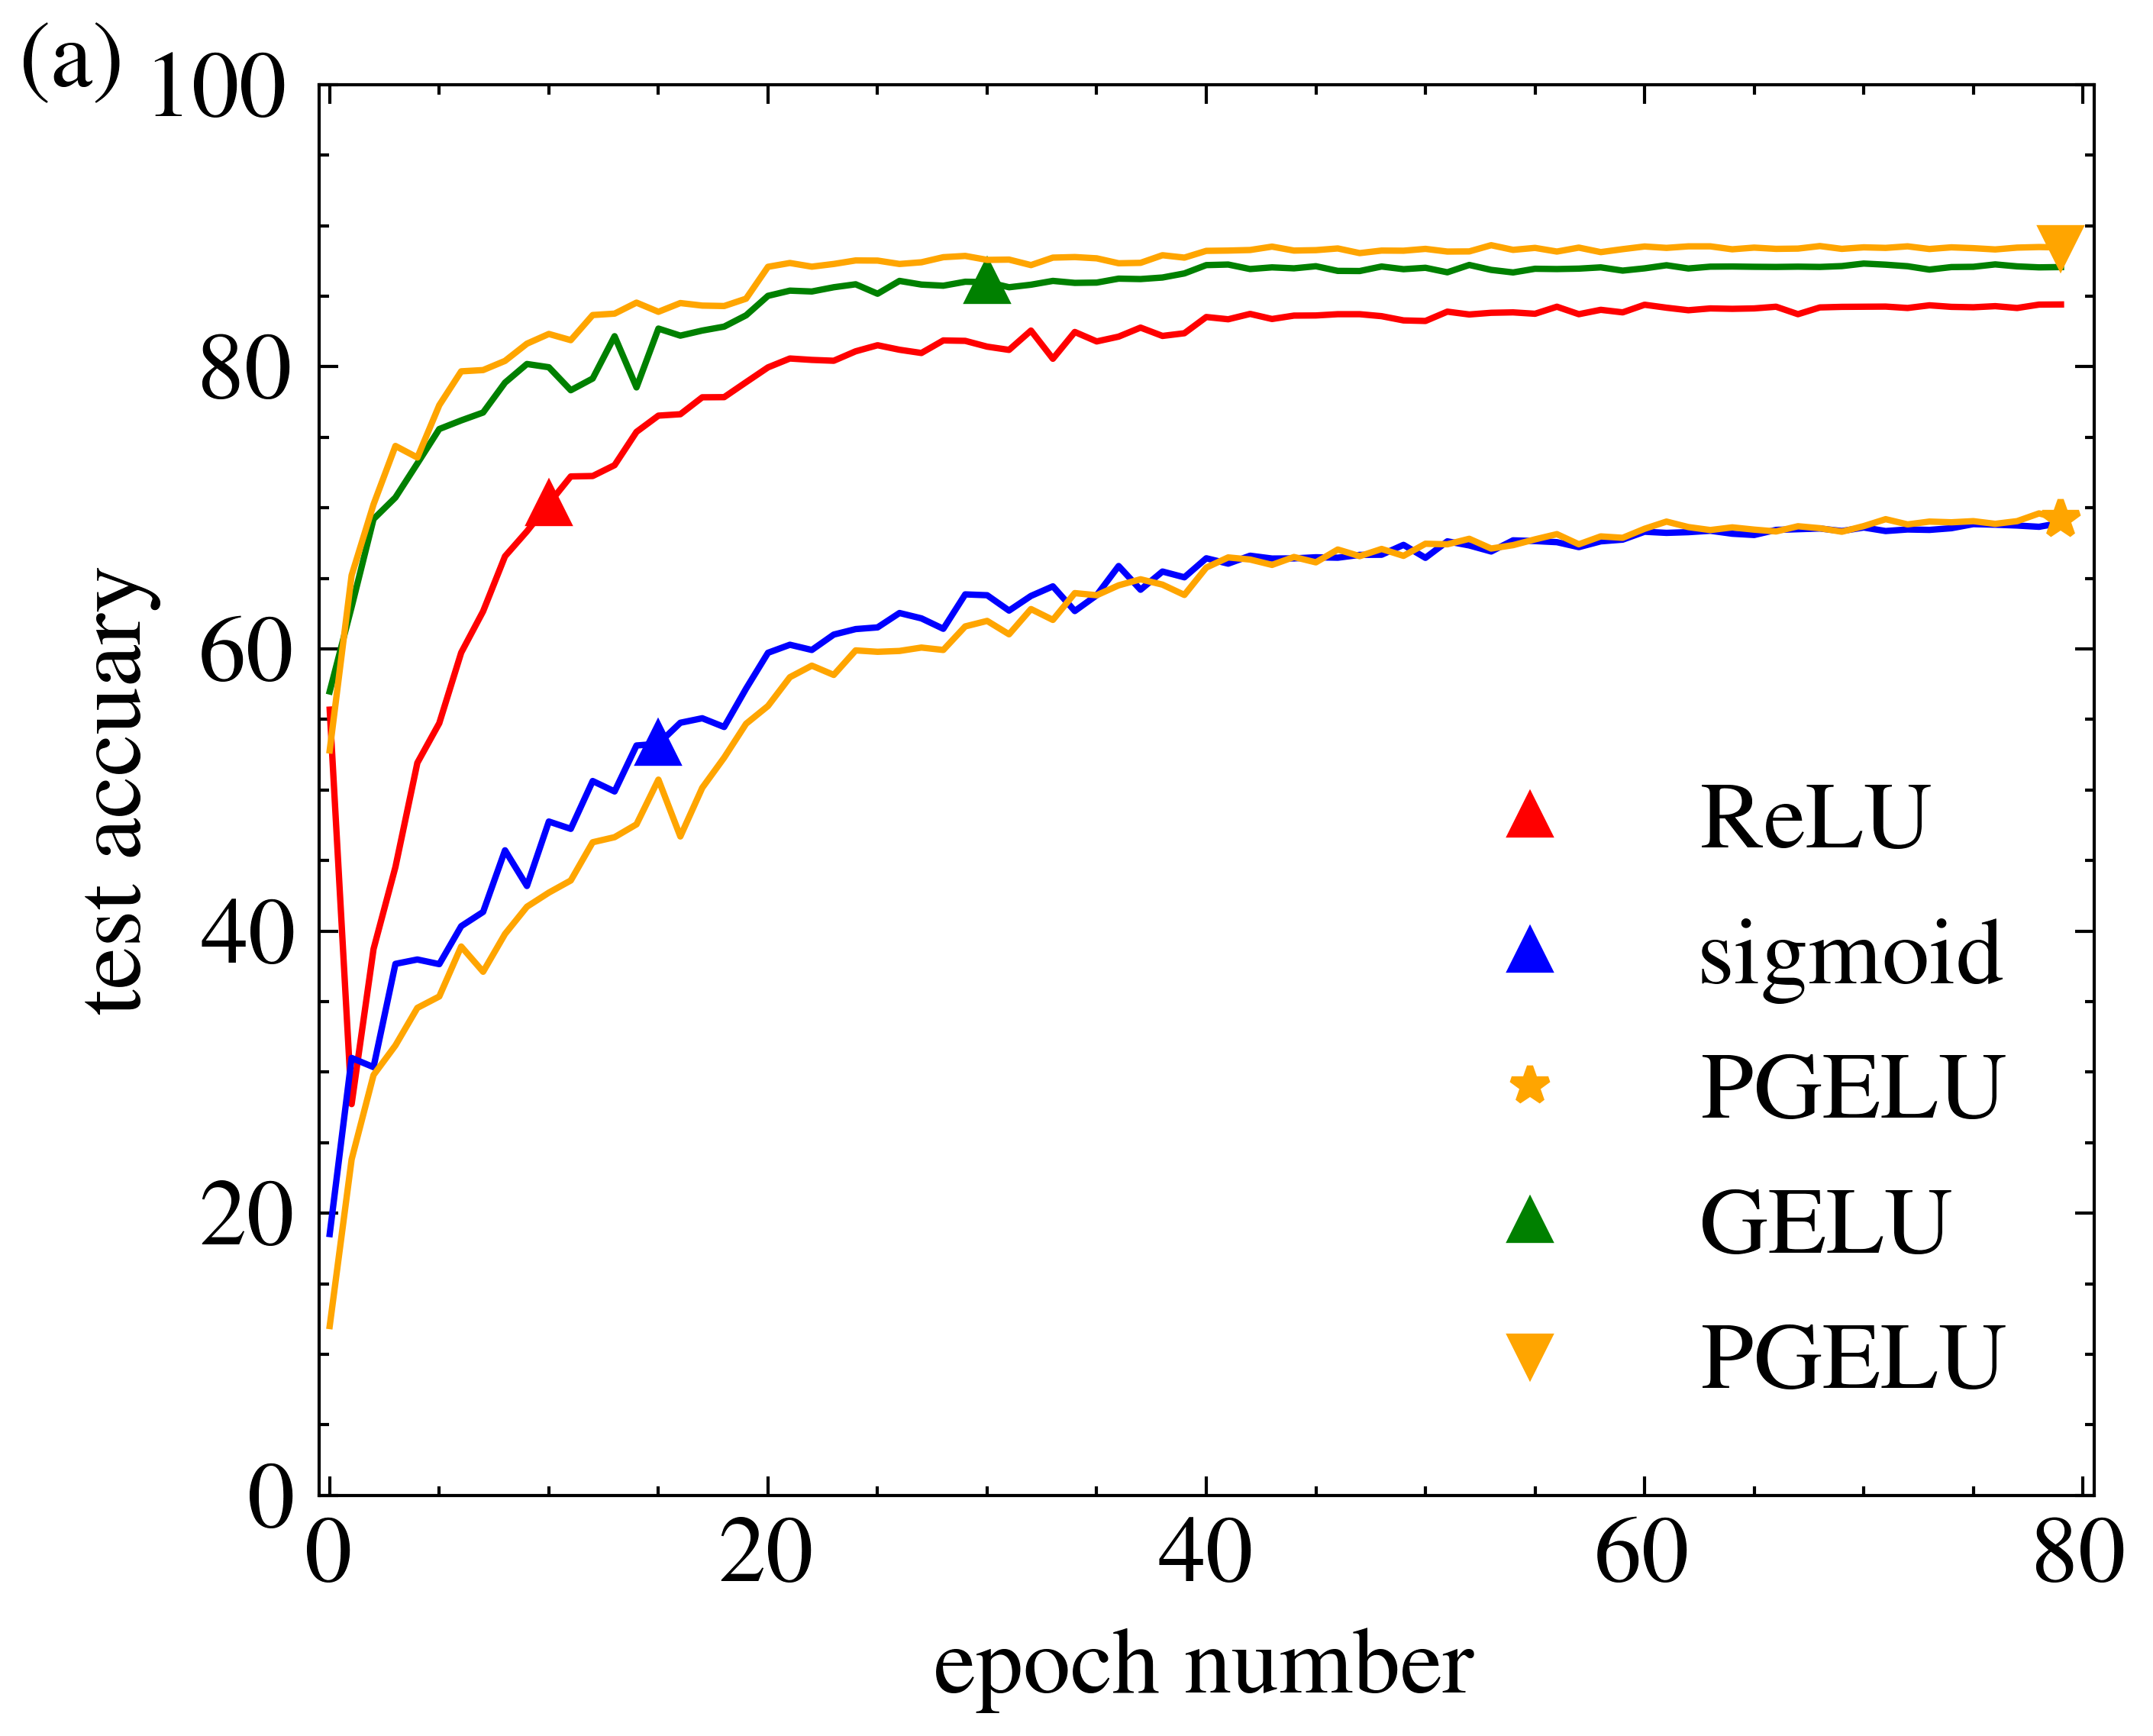

In [32]:
import pandas as pd
import scienceplots
historycifarelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historycifarelu.csv')
historycifasigmoid=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historycifasigmoid.csv')
historycifagelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historycifagelu.csv')
historycifapgelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historycifapgelu.csv')
historycifageu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historycifageu.csv')
#import scienceplots 
import math
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel('test accuary', fontsize=15, labelpad = -1)
ax.set_xlim(-0.5, 80.5)
ax.set_ylim(0, 100)


xrelu = range(0, 80)
yrelu = historycifarelu['relu_valid_acc']
plt.plot(xrelu, yrelu, '-',color ='r')
plt.plot(xrelu[10], yrelu[10], '^',color ='r',label='ReLU')


xsigmoid = range(0, 80)
ysigmoid = historycifasigmoid['SIGMOID_valid_acc']
plt.plot(xsigmoid, ysigmoid, '-',color ='b')
plt.plot(xsigmoid[15], ysigmoid[15], '^',color ='b',label='sigmoid')

xgeu = range(0, 80)
ygeu = historycifageu['GEU_valid_acc']
plt.plot(xgeu, ygeu, '-',color ='orange')
plt.plot(xgeu[79], ygeu[79], '*',color ='orange',label='PGELU')


xgelu = range(0, 80)
ygelu = historycifagelu['GELU_valid_acc']
plt.plot(xgelu, ygelu, '-',color ='g')
plt.plot(xgelu[30], ygelu[30], '^',color ='g',label='GELU')

xpgelu = range(0, 80)
ypgelu = historycifapgelu['PGELU_valid_acc']
plt.plot(xpgelu, ypgelu, '-',color ='orange')
plt.plot(xpgelu[79], ypgelu[79], 'v',color ='orange',label='PGELU')

ax.legend(loc='lower right', fontsize=15)
ax.text(-14, 99.8, '(a)',fontdict={'size': 15, 'color':  'black'})
plt.show()
#fig.savefig('D:/IEEE 2022 general AF/neural networks2023/figminsta.eps', dpi=800)

In [ ]:
self.prelu1 = nn.PReLU()
self.prelu2 = nn.PReLU()
self.prelu3 = nn.PReLU()

In [3]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        #self.relu = nn.ReLU()
        # self.pgelu1 = Pgelu()
        # self.pgelu2 = Pgelu()
        self.prelu1 = nn.PReLU()
        self.prelu2 = nn.PReLU()
        
        
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        #out = self.relu(out)
        #out = self.pgelu1(out)
        out = self.prelu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        #out = self.pgelu2(out)
        out = self.prelu2(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        #self.relu = nn.ReLU()
        #self.pgelu3 = Pgelu()
        self.prelu3 = nn.PReLU()
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        #out = self.relu(out)
        #out = self.pgelu3(out)
        out = self.prelu3(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
#model1 = ResidualBlock()
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

In [4]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate


historycifaprelu={'prelu_train_loss':[],'prelu_valid_loss':[],'prelu_train_acc':[],'prelu_valid_acc':[]}
num_epochs=80

for epoch in range(num_epochs):
    prelu_train_loss,prelu_train_correct=0.0,0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        prelu_train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(outputs.data, 1)#最大化输出得到标签0-9
        prelu_train_correct += (predictions == labels).sum().item() #对比标签得到正确的标签个数   
        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)
    prelu_valid_loss, prelu_val_correct = 0.0, 0
    model.eval()#评估模式,非训练模式,batch normalization 和 dropout关闭
    for images, labels in test_loader:

        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        loss=criterion(outputs,labels)
        prelu_valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(outputs.data,1)#最大化输出得到标签0-9
        prelu_val_correct+=(predictions == labels).sum().item()#对比标签得到正确的标签个数

    prelu_train_loss = prelu_train_loss / len(train_loader.sampler)#除以48000
    prelu_train_acc = prelu_train_correct / len(train_loader.sampler)*100
    prelu_valid_loss = prelu_valid_loss / len(test_loader.sampler)#除以12000
    prelu_valid_acc = prelu_val_correct / len(test_loader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs,
                                                                                         prelu_train_loss,
                                                                                         prelu_valid_loss,
                                                                                         prelu_train_acc,
                                                                                        prelu_valid_acc))
    historycifaprelu['prelu_train_loss'].append(prelu_train_loss)#每次训练和验证记录下来，后面画图   
    historycifaprelu['prelu_valid_loss'].append(prelu_valid_loss)  
    historycifaprelu['prelu_train_acc'].append(prelu_train_acc)  
    historycifaprelu['prelu_valid_acc'].append(prelu_valid_acc) 

Epoch [1/80], Step [100/500] Loss: 1.6444
Epoch [1/80], Step [200/500] Loss: 1.5984
Epoch [1/80], Step [300/500] Loss: 1.4404
Epoch [1/80], Step [400/500] Loss: 1.4898
Epoch [1/80], Step [500/500] Loss: 1.1333
Epoch:1/80 	 AVERAGE TL:1.4654 AVERAGE VL:1.2054 	 AVERAGE TA:45.86 %  AVERAGE VA:58.06 %
Epoch [2/80], Step [100/500] Loss: 2.0867
Epoch [2/80], Step [200/500] Loss: 1.5637
Epoch [2/80], Step [300/500] Loss: 1.6774
Epoch [2/80], Step [400/500] Loss: 1.3871
Epoch [2/80], Step [500/500] Loss: 1.2733
Epoch:2/80 	 AVERAGE TL:1.6095 AVERAGE VL:1.2073 	 AVERAGE TA:40.02 %  AVERAGE VA:55.75 %
Epoch [3/80], Step [100/500] Loss: 1.1260
Epoch [3/80], Step [200/500] Loss: 1.1912
Epoch [3/80], Step [300/500] Loss: 1.1823
Epoch [3/80], Step [400/500] Loss: 1.1305
Epoch [3/80], Step [500/500] Loss: 1.0248
Epoch:3/80 	 AVERAGE TL:1.1187 AVERAGE VL:1.0570 	 AVERAGE TA:59.55 %  AVERAGE VA:62.42 %
Epoch [4/80], Step [100/500] Loss: 0.9206
Epoch [4/80], Step [200/500] Loss: 1.0729
Epoch [4/80], St

In [5]:
import pandas as pd
frame1=pd.DataFrame(historycifaprelu)
frame1.to_csv('D:/IEEE 2022 general AF/neural networks2023/historycifaprelu.csv')

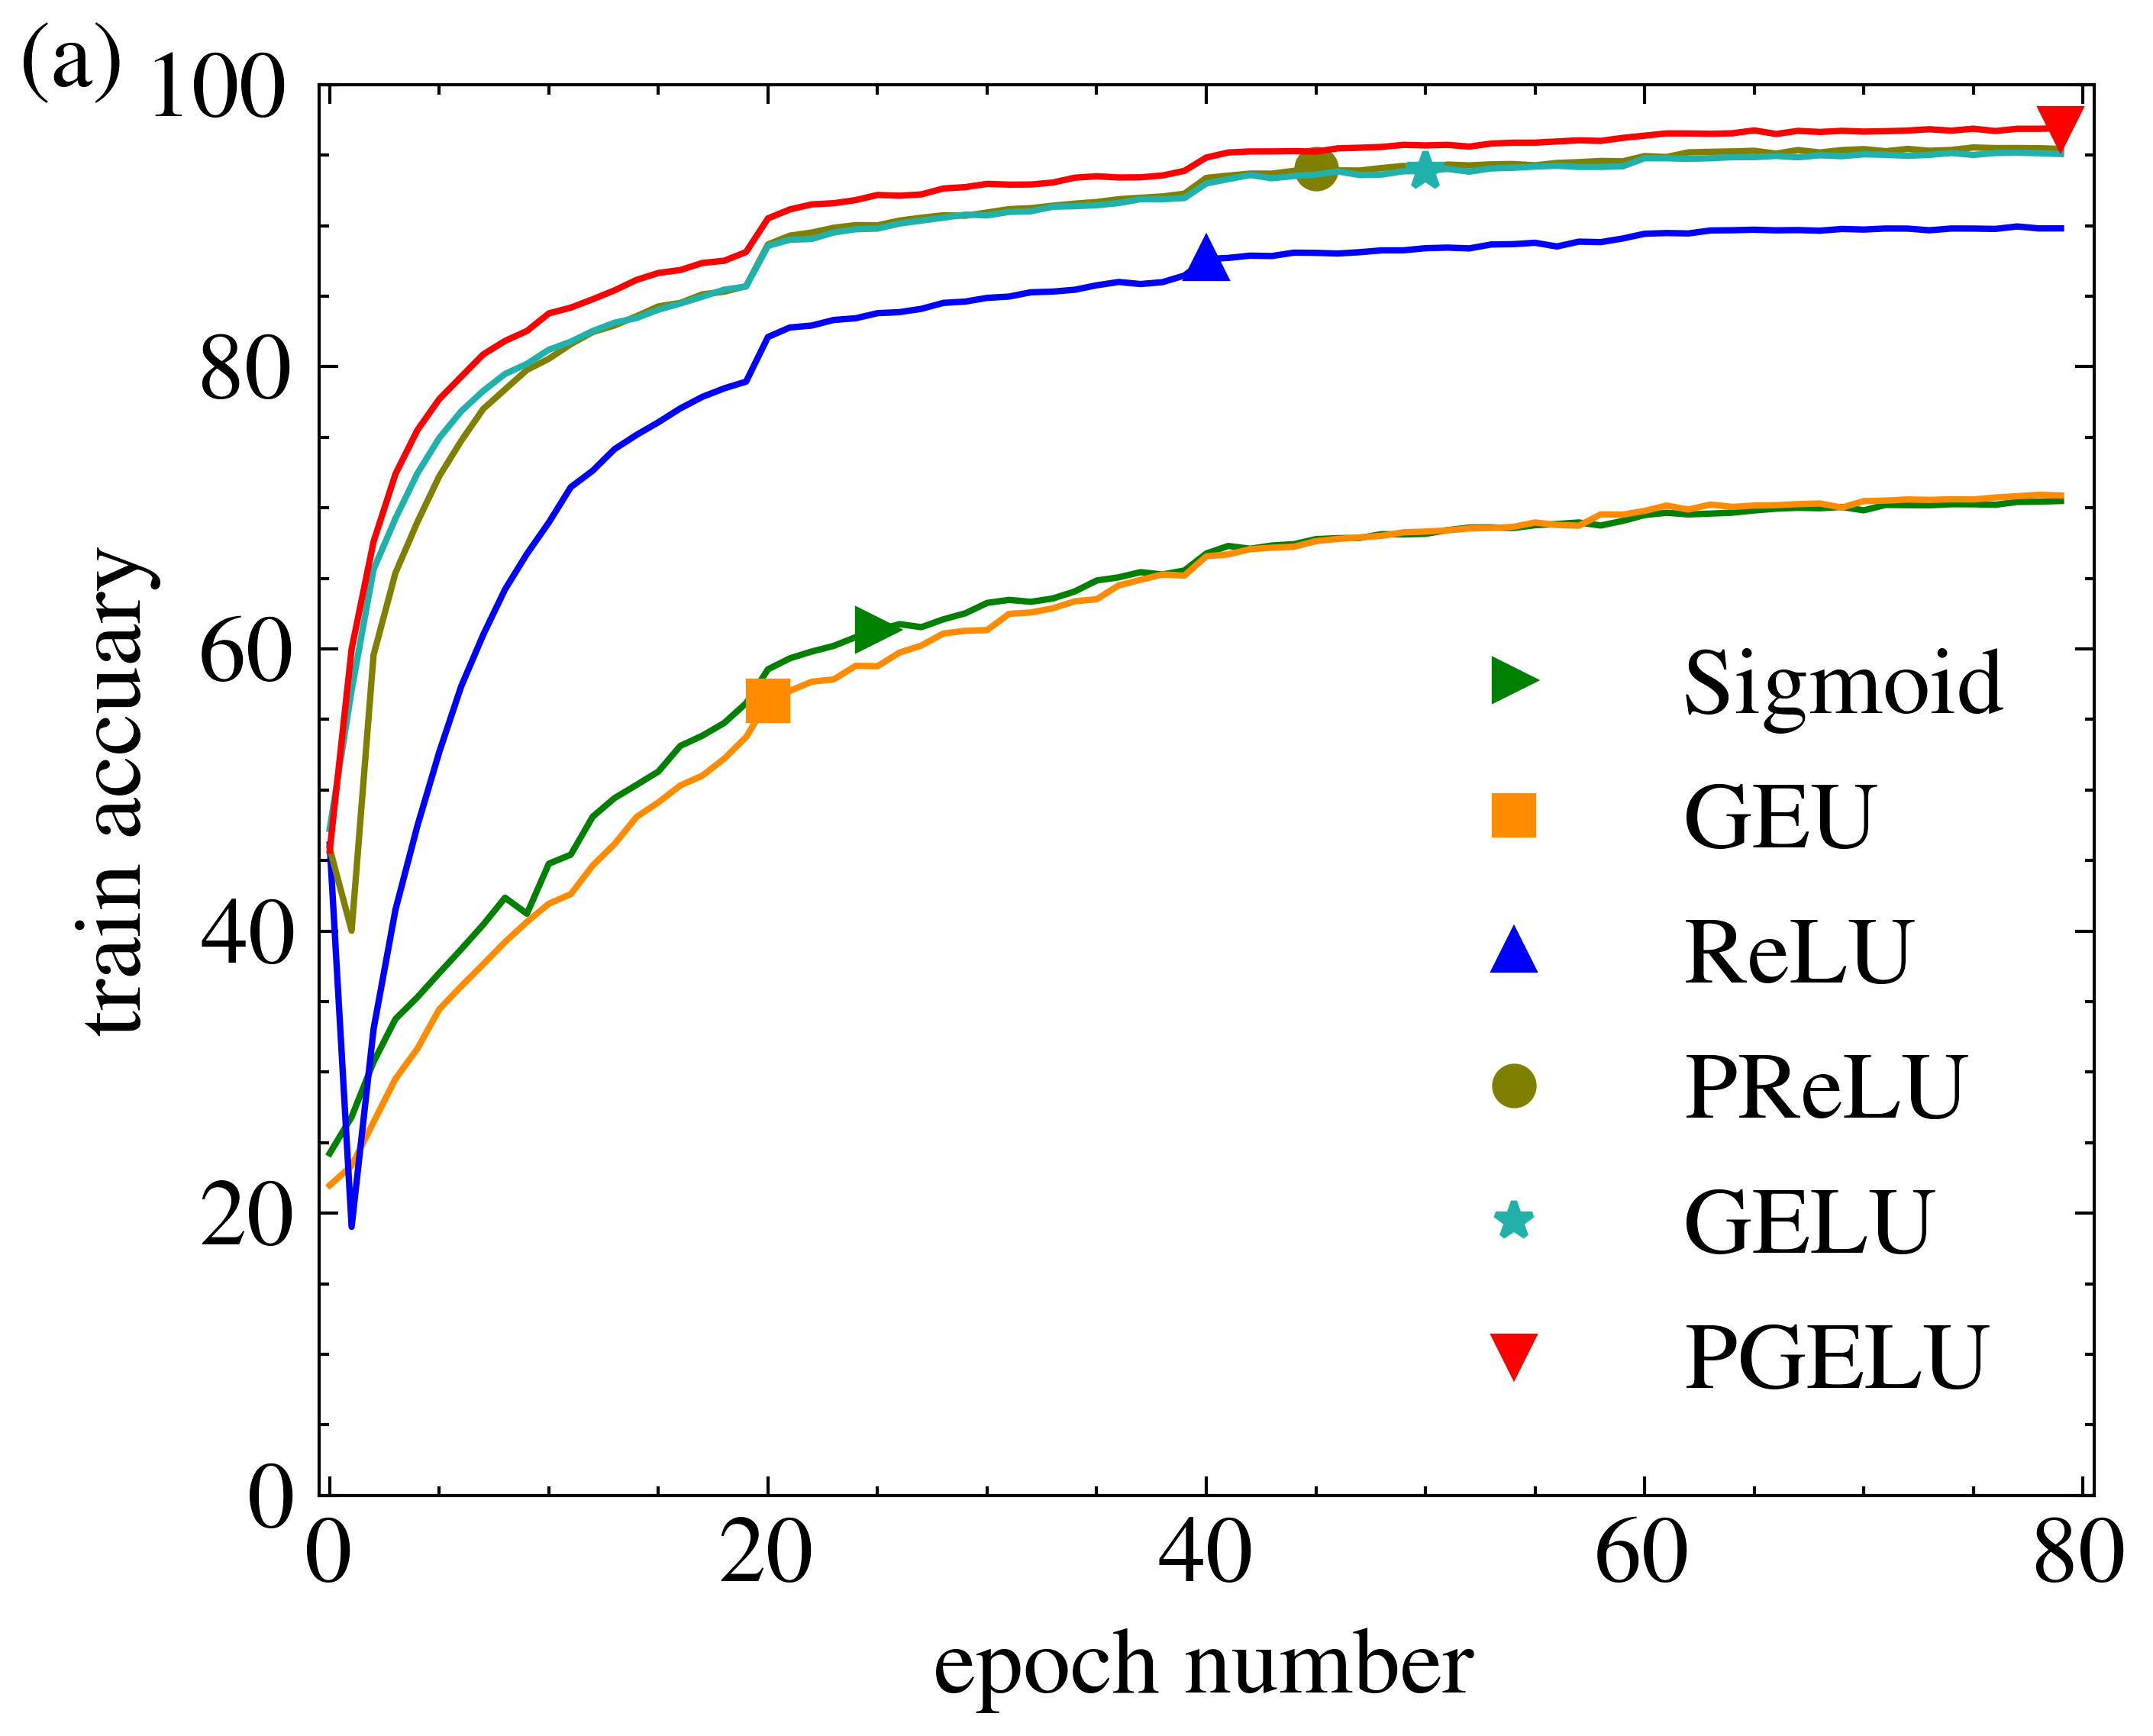

In [4]:
import pandas as pd
import scienceplots
historycifarelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historycifarelu.csv')
historycifaprelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historycifaprelu.csv')
historycifasigmoid=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historycifasigmoid.csv')
historycifagelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historycifagelu.csv')
historycifapgelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historycifapgelu.csv')
historycifageu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historycifageu.csv')
#import scienceplots 
import math
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel('train accuary', fontsize=15, labelpad = -1)
ax.set_xlim(-0.5, 80.5)
ax.set_ylim(0, 100)

xsigmoid = range(0, 80)
ysigmoid = historycifasigmoid['SIGMOID_train_acc']
plt.plot(xsigmoid, ysigmoid, '-',color ='g')
plt.plot(xsigmoid[25], ysigmoid[25], '>',color ='g',label='Sigmoid')

xgeu = range(0, 80)
ygeu = historycifageu['GEU_train_acc']
plt.plot(xgeu, ygeu, '-',color ='darkorange')
plt.plot(xgeu[20], ygeu[20], 's',color ='darkorange',label='GEU')


xrelu = range(0, 80)
yrelu = historycifarelu['relu_train_acc']
plt.plot(xrelu, yrelu, '-',color ='b')
plt.plot(xrelu[40], yrelu[40], '^',color ='b',label='ReLU')

xprelu = range(0, 80)
yprelu = historycifaprelu['prelu_train_acc']
plt.plot(xprelu, yprelu, '-',color ='olive')
plt.plot(xprelu[45], yprelu[45], 'o',color ='olive',label='PReLU')

xgelu = range(0, 80)
ygelu = historycifagelu['GELU_train_acc']
plt.plot(xgelu, ygelu, '-',color ='lightseagreen')
plt.plot(xgelu[50], ygelu[50], '*',color ='lightseagreen',label='GELU')

xpgelu = range(0, 80)
ypgelu = historycifapgelu['PGELU_train_acc']
plt.plot(xpgelu, ypgelu, '-',color ='r')
plt.plot(xpgelu[79], ypgelu[79], 'v',color ='r',label='PGELU')

ax.legend(loc='lower right', fontsize=15)
ax.text(-14, 99.8, '(a)',fontdict={'size': 15, 'color':  'black'})
plt.show()
fig.savefig('D:/IEEE 2022 general AF/neural networks2023/figcifaa.eps', dpi=800)

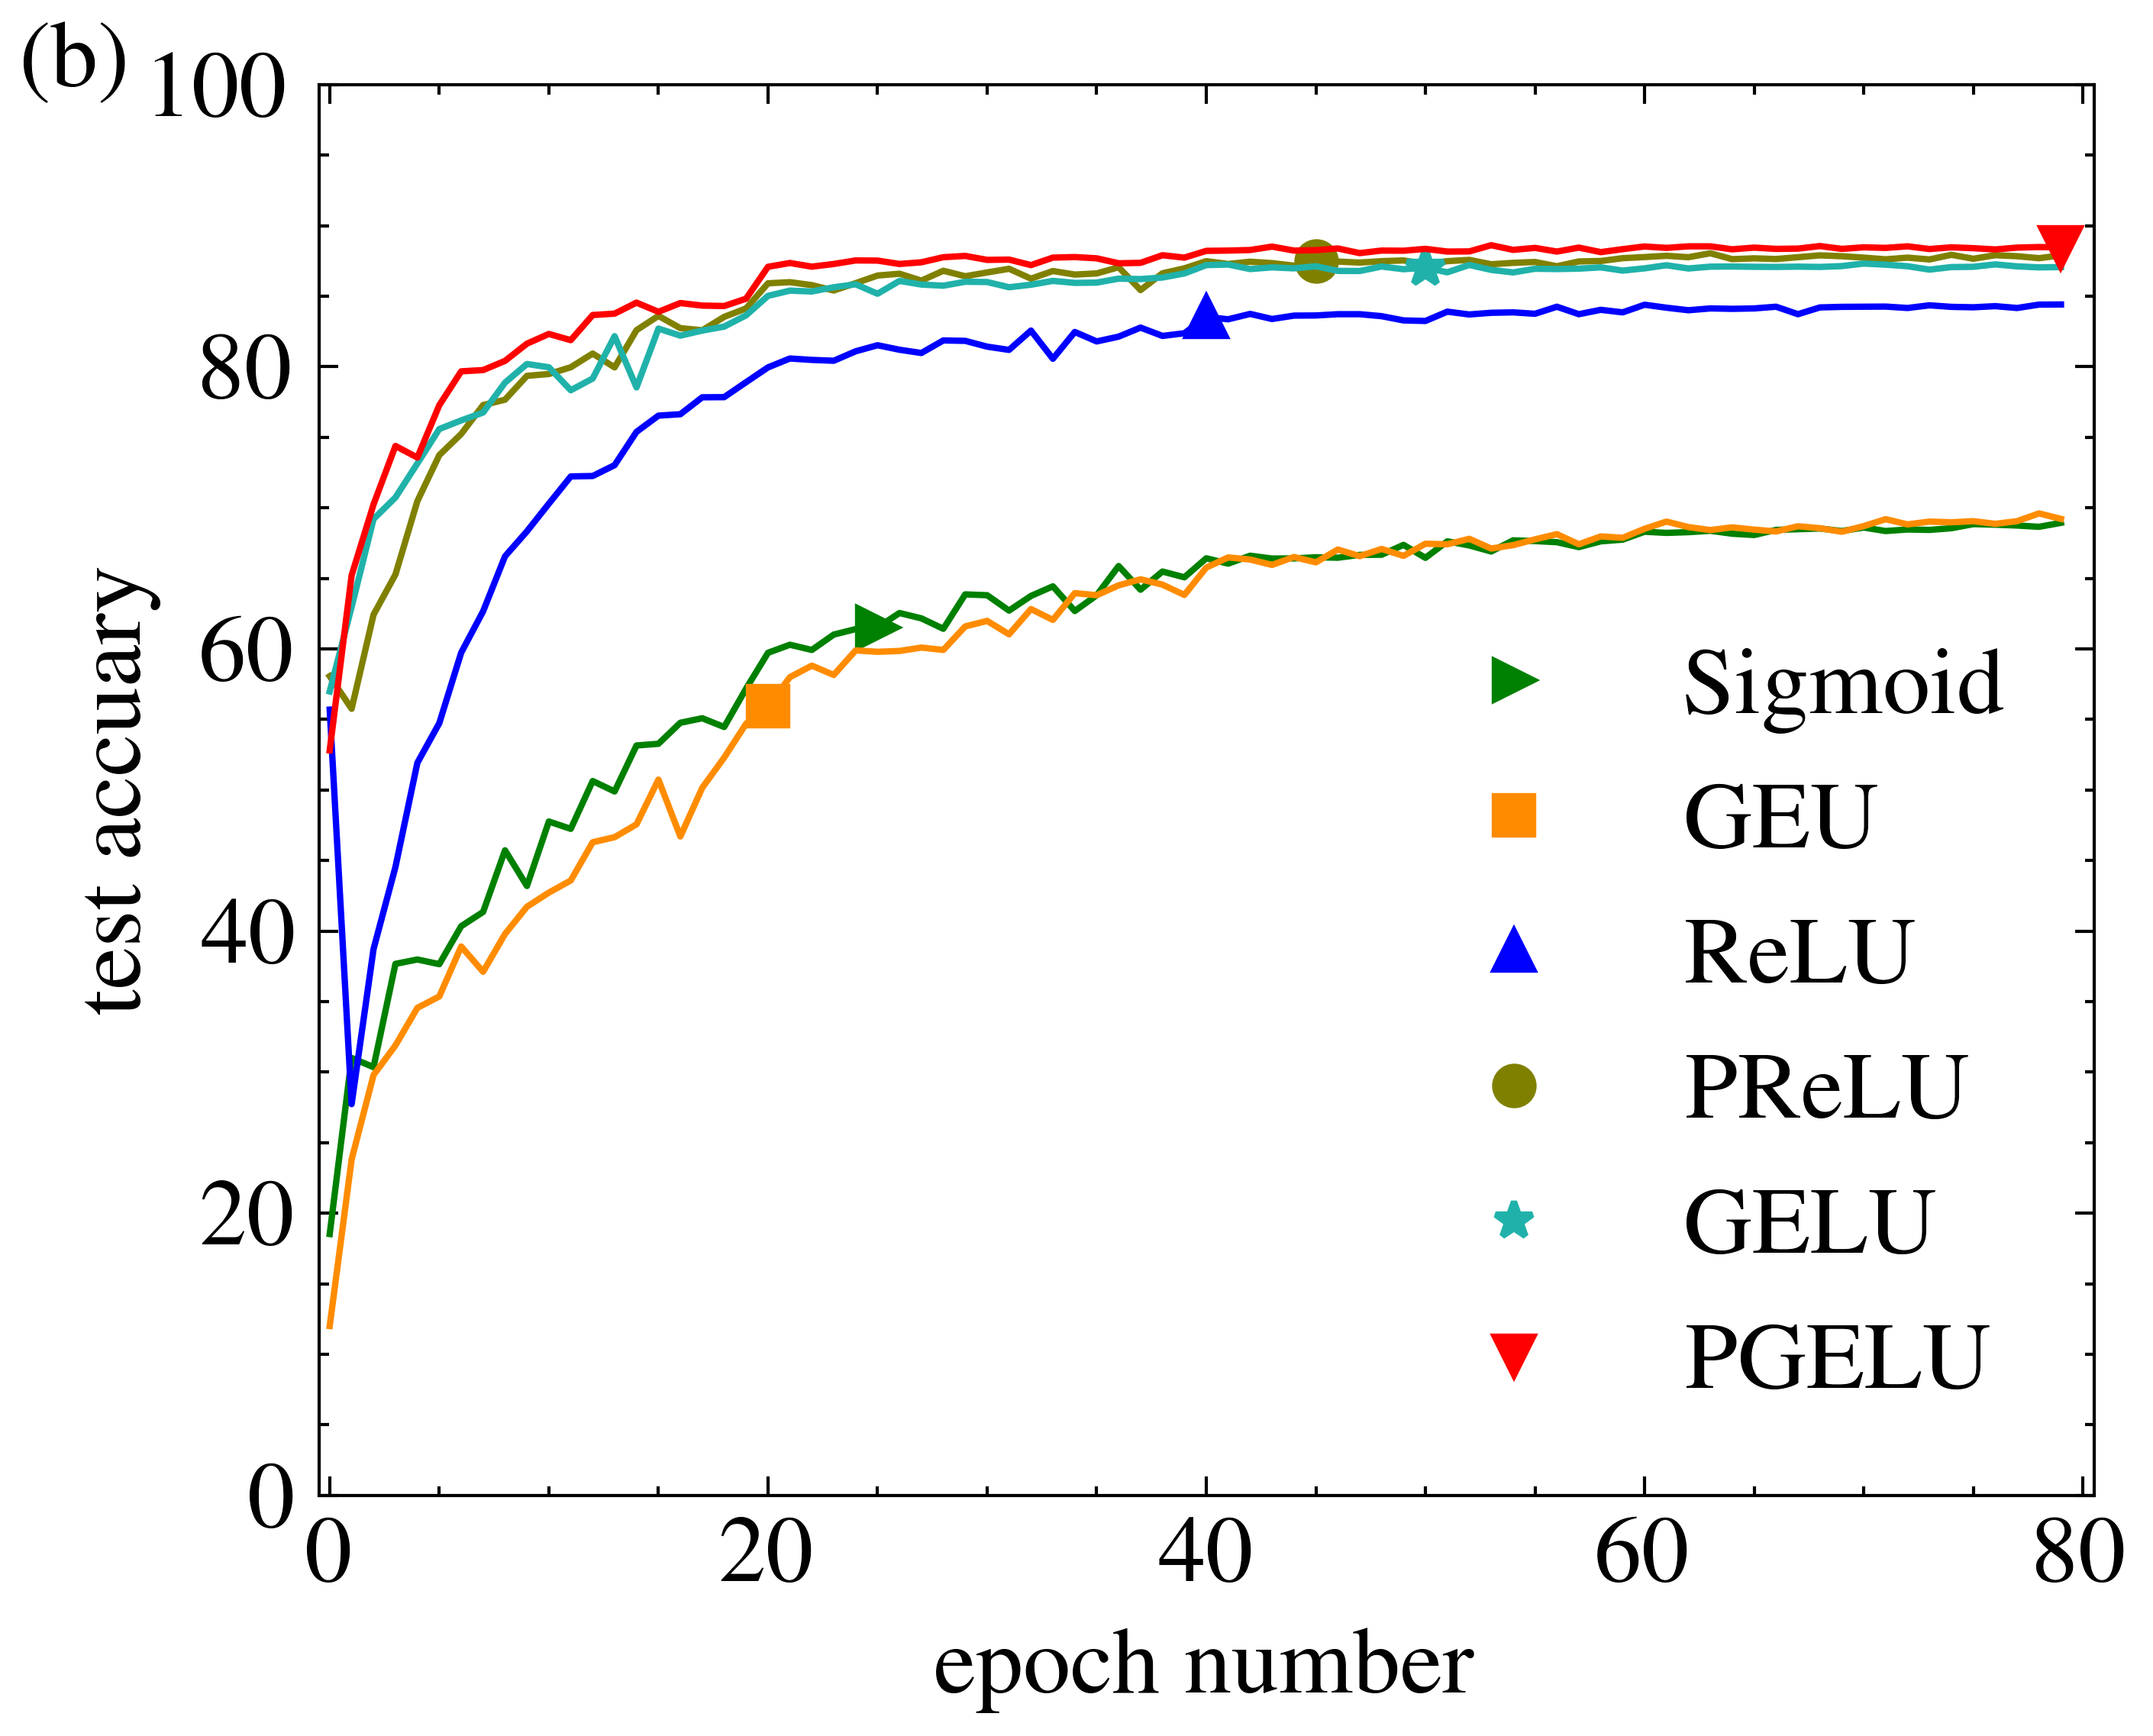

In [5]:
import pandas as pd
import scienceplots
historycifarelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historycifarelu.csv')

historycifaprelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historycifaprelu.csv')
historycifasigmoid=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historycifasigmoid.csv')
historycifagelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historycifagelu.csv')
historycifapgelu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historycifapgelu.csv')
historycifageu=pd.read_csv('D:/IEEE 2022 general AF/neural networks2023/historycifageu.csv')
#import scienceplots 
import math
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel('test accuary', fontsize=15, labelpad = -1)
ax.set_xlim(-0.5, 80.5)
ax.set_ylim(0, 100)

xsigmoid = range(0, 80)
ysigmoid = historycifasigmoid['SIGMOID_valid_acc']
plt.plot(xsigmoid, ysigmoid, '-',color ='g')
plt.plot(xsigmoid[25], ysigmoid[25], '>',color ='g',label='Sigmoid')

xgeu = range(0, 80)
ygeu = historycifageu['GEU_valid_acc']
plt.plot(xgeu, ygeu, '-',color ='darkorange')
plt.plot(xgeu[20], ygeu[20], 's',color ='darkorange',label='GEU')


xrelu = range(0, 80)
yrelu = historycifarelu['relu_valid_acc']
plt.plot(xrelu, yrelu, '-',color ='b')
plt.plot(xrelu[40], yrelu[40], '^',color ='b',label='ReLU')

xprelu = range(0, 80)
yprelu = historycifaprelu['prelu_valid_acc']
plt.plot(xprelu, yprelu, '-',color ='olive')
plt.plot(xprelu[45], yprelu[45], 'o',color ='olive',label='PReLU')

xgelu = range(0, 80)
ygelu = historycifagelu['GELU_valid_acc']
plt.plot(xgelu, ygelu, '-',color ='lightseagreen')
plt.plot(xgelu[50], ygelu[50], '*',color ='lightseagreen',label='GELU')

xpgelu = range(0, 80)
ypgelu = historycifapgelu['PGELU_valid_acc']
plt.plot(xpgelu, ypgelu, '-',color ='r')
plt.plot(xpgelu[79], ypgelu[79], 'v',color ='r',label='PGELU')

ax.legend(loc='lower right', fontsize=15)
ax.text(-14, 99.8, '(b)',fontdict={'size': 15, 'color':  'black'})
plt.show()
fig.savefig('D:/IEEE 2022 general AF/neural networks2023/figcifab.eps', dpi=800)